In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             

sns.set_style("darkgrid")

PATH ='/home/antixk/Anand/' #'/home/robot/Anand/'
sys.path.append(PATH)

from NeuralBlocks.models.vgg import VGG
from NeuralBlocks.models.densenet import DenseNet

In [2]:
torch.manual_seed(2456)
cudnn.deterministic = True
cudnn.benchmark = False
np.random.seed(2456)

NUM_EPOCH = 200
BATCH_SIZE = 128
CHECKPOINT_INTERVAL = 100
LRS = [0.0001, 0.001, 0.01]
NORMS =[None,'BN', 'SN', 'WN','MWN', 'MSN', 'MSNTReLU', 'MWNTReLU']
DATA_PATH = PATH+"NeuralBlocks/data_utils/datasets/KMNIST/"
SAVE_PATH = PATH+"NeuralBlocks/experiments/KMNIST/"

os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
transform_train = transforms.Compose(
    [#transforms.RandomAffine(degrees=7, translate=(0.1, 0.1), scale=(0.95, 1.05)), 
     transforms.ToTensor(),
     transforms.Normalize((0.19036,), (0.34743,)),
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.19036,), (0.34743,)),
    ])

trainset = torchvision.datasets.KMNIST(root=DATA_PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

testset = torchvision.datasets.KMNIST(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [4]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        train_loss_log.append(train_loss/(batch_idx+1))
        train_acc_log.append( 100.*correct/total)
        
        if(batch_idx%CHECKPOINT_INTERVAL==0):
             print("Train Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(trainloader),
                train_loss/(batch_idx+1), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            test_loss_log.append(test_loss/(batch_idx+1))
            test_acc_log.append( 100.*correct/total)
        
            if(batch_idx%CHECKPOINT_INTERVAL==0):
                print("Test Epoch [{:3d}/{:3d}]Batch [{:3d}/{:3d}] Loss: {:.3f} Acc {:.3f}%".format(epoch, NUM_EPOCH,batch_idx, len(testloader),
                test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(SAVE_PATH+'checkpoint'):
            os.mkdir(SAVE_PATH+'checkpoint')
        torch.save(state, SAVE_PATH+'checkpoint/ckpt.pth')
        best_acc = acc

In [8]:
best_acc = 0 
for lr in tqdm_notebook(LRS):
    for norm in tqdm_notebook(NORMS):
        net =  VGG(11,1, num_class=10, norm=norm).cuda()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)

        train_loss_log =[]
        train_acc_log = []
        test_loss_log =[]
        test_acc_log =[]

        for epoch in tqdm_notebook(range(NUM_EPOCH)):
            train(epoch)
            test(epoch)

        np.save(SAVE_PATH+"VGG_Train_loss_{}_{}.npy".format(norm,lr), train_loss_log)  
        np.save(SAVE_PATH+"VGG_Test_loss_{}_{}.npy".format(norm,lr), test_loss_log)    
        np.save(SAVE_PATH+"VGG_Train_Acc_{}_{}.npy".format(norm,lr), train_acc_log)    
        np.save(SAVE_PATH+"VGG_Test_Acc_{}_{}.npy".format(norm,lr), test_acc_log)   
        del net

Train Epoch [  0/200]Batch [  0/469] Loss: 2.303 Acc 8.594%
Train Epoch [  0/200]Batch [100/469] Loss: 1.792 Acc 35.079%
Train Epoch [  0/200]Batch [200/469] Loss: 1.405 Acc 49.600%
Train Epoch [  0/200]Batch [300/469] Loss: 1.173 Acc 58.583%
Train Epoch [  0/200]Batch [400/469] Loss: 1.017 Acc 64.456%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.727 Acc 75.000%
Saving..
Train Epoch [  1/200]Batch [  0/469] Loss: 0.396 Acc 89.062%
Train Epoch [  1/200]Batch [100/469] Loss: 0.398 Acc 87.082%
Train Epoch [  1/200]Batch [200/469] Loss: 0.369 Acc 88.052%
Train Epoch [  1/200]Batch [300/469] Loss: 0.353 Acc 88.645%
Train Epoch [  1/200]Batch [400/469] Loss: 0.331 Acc 89.366%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.623 Acc 78.125%
Saving..
Train Epoch [  2/200]Batch [  0/469] Loss: 0.268 Acc 89.844%
Train Epoch [  2/200]Batch [100/469] Loss: 0.218 Acc 93.131%
Train Epoch [  2/200]Batch [200/469] Loss: 0.207 Acc 93.443%
Train Epoch [  2/200]Batch [300/469] Loss: 0.195 Acc 93.875%
Train Epo

Train Epoch [ 22/200]Batch [200/469] Loss: 0.005 Acc 99.852%
Train Epoch [ 22/200]Batch [300/469] Loss: 0.005 Acc 99.842%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.005 Acc 99.819%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.253 Acc 93.750%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.004 Acc 99.892%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.003 Acc 99.911%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.917%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.906%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.314 Acc 94.531%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.011 Acc 99.691%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.008 Acc 99.775%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.007 Acc 99.795%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.007 Acc 99.782%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.204 Acc 95.312%
Train Epoch [ 25/200]Batc

Train Epoch [ 44/200]Batch [400/469] Loss: 0.002 Acc 99.961%
Test Epoch [ 44/200]Batch [  0/ 79] Loss: 0.274 Acc 94.531%
Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.001 Acc 99.992%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.001 Acc 99.988%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 99.987%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.317 Acc 95.312%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.006 Acc 99.799%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.005 Acc 99.845%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.005 Acc 99.836%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.005 Acc 99.848%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.256 Acc 95.312%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.002 Acc 99.938%
Train Epoch [ 47/200]Batc

Train Epoch [ 67/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.492 Acc 96.094%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.506 Acc 96.094%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [ 89/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.601 Acc 96.094%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.607 Acc 96.094%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [

Train Epoch [111/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [111/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [111/200]Batch [  0/ 79] Loss: 0.553 Acc 94.531%
Train Epoch [112/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.571 Acc 94.531%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.582 Acc 94.531%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [133/200]Batch [400/469] Loss: 0.000 Acc 99.988%
Test Epoch [133/200]Batch [  0/ 79] Loss: 0.179 Acc 98.438%
Train Epoch [134/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 99.994%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.182 Acc 98.438%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.187 Acc 97.656%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/2

Test Epoch [155/200]Batch [  0/ 79] Loss: 0.331 Acc 97.656%
Train Epoch [156/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.337 Acc 98.438%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.342 Acc 97.656%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [178/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [178/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [178/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [178/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [178/200]Batch [  0/ 79] Loss: 0.337 Acc 97.656%
Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.339 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [

Train Epoch [  0/200]Batch [  0/469] Loss: 2.328 Acc 5.469%
Train Epoch [  0/200]Batch [100/469] Loss: 0.853 Acc 84.158%
Train Epoch [  0/200]Batch [200/469] Loss: 0.532 Acc 90.326%
Train Epoch [  0/200]Batch [300/469] Loss: 0.402 Acc 92.460%
Train Epoch [  0/200]Batch [400/469] Loss: 0.326 Acc 93.750%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.227 Acc 92.969%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.062 Acc 97.656%
Train Epoch [  1/200]Batch [100/469] Loss: 0.060 Acc 98.523%
Train Epoch [  1/200]Batch [200/469] Loss: 0.052 Acc 98.698%
Train Epoch [  1/200]Batch [300/469] Loss: 0.048 Acc 98.762%
Train Epoch [  1/200]Batch [400/469] Loss: 0.048 Acc 98.763%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.189 Acc 93.750%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [  2/200]Batch [100/469] Loss: 0.025 Acc 99.412%
Train Epoch [  2/200]Batch [200/469] Loss: 0.022 Acc 99.475%
Train Epoch [  2/200]Batch [300/469] Loss: 0.024 Acc 99.400%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.002 Acc 99.964%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.897%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.119 Acc 97.656%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.006 Acc 99.845%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.920%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.918%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.112 Acc 97.656%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.002 Acc 99.969%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.001 Acc 99.963%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.238 Acc 95.312%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Test Epoch [ 44/200]Batch [  0/ 79] Loss: 0.148 Acc 97.656%
Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.185 Acc 96.094%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.004 Acc 99.915%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.003 Acc 99.911%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.003 Acc 99.920%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.003 Acc 99.914%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.148 Acc 99.219%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.004 Acc 99.899%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.003 Acc 99.922%
Train Epoch [ 47/200]Bat

Train Epoch [ 67/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [100/469] Loss: 0.003 Acc 99.899%
Train Epoch [ 67/200]Batch [200/469] Loss: 0.005 Acc 99.848%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.006 Acc 99.805%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.006 Acc 99.821%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.247 Acc 96.875%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.021 Acc 99.219%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.004 Acc 99.876%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.003 Acc 99.887%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.003 Acc 99.896%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.003 Acc 99.916%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.142 Acc 99.219%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 99.984%
Train Epoch [ 69/200]Bat

Train Epoch [ 89/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.163 Acc 98.438%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.213 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.004 Acc 99.930%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.004 Acc 99.891%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.005 Acc 99.868%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.005 Acc 99.879%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.187 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 92/2

Test Epoch [111/200]Batch [  0/ 79] Loss: 0.170 Acc 98.438%
Train Epoch [112/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [112/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [112/200]Batch [300/469] Loss: 0.001 Acc 99.974%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.157 Acc 98.438%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [113/200]Batch [400/469] Loss: 0.001 Acc 99.984%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.155 Acc 98.438%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [114/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [114/200]Bat

Train Epoch [134/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.167 Acc 99.219%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.163 Acc 99.219%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [

Train Epoch [156/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [156/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.202 Acc 96.094%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [157/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [157/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [157/200]Batch [400/469] Loss: 0.001 Acc 99.979%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.185 Acc 97.656%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [158/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 99.984%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 99.986%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.220 Acc 96.875%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Bat

Test Epoch [178/200]Batch [  0/ 79] Loss: 0.163 Acc 98.438%
Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.189 Acc 98.438%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.177 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [  0/200]Batch [  0/469] Loss: 2.306 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 1.691 Acc 39.805%
Train Epoch [  0/200]Batch [200/469] Loss: 1.337 Acc 52.997%
Train Epoch [  0/200]Batch [300/469] Loss: 1.118 Acc 61.355%
Train Epoch [  0/200]Batch [400/469] Loss: 0.966 Acc 66.919%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.682 Acc 77.344%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.259 Acc 92.188%
Train Epoch [  1/200]Batch [100/469] Loss: 0.348 Acc 89.024%
Train Epoch [  1/200]Batch [200/469] Loss: 0.313 Acc 90.034%
Train Epoch [  1/200]Batch [300/469] Loss: 0.289 Acc 90.900%
Train Epoch [  1/200]Batch [400/469] Loss: 0.270 Acc 91.552%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.403 Acc 89.062%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.147 Acc 96.875%
Train Epoch [  2/200]Batch [100/469] Loss: 0.159 Acc 95.212%
Train Epoch [  2/200]Batch [200/469] Loss: 0.149 Acc 95.449%
Train Epoch [  2/200]Batch [300/469] Loss: 0.142 Acc 95.621%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.007 Acc 99.816%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.006 Acc 99.852%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.223 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.006 Acc 99.838%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.004 Acc 99.887%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.917%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.914%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.163 Acc 96.875%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.006 Acc 99.838%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.004 Acc 99.887%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.004 Acc 99.883%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.005 Acc 99.875%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.172 Acc 96.094%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 25/200]Bat

Test Epoch [ 44/200]Batch [  0/ 79] Loss: 0.251 Acc 96.875%
Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.258 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.262 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Train Epoch [ 67/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.363 Acc 96.875%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.357 Acc 96.875%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [ 89/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.328 Acc 96.094%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.336 Acc 96.094%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.341 Acc 96.094%
Train Epoch [ 

Train Epoch [111/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [111/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [111/200]Batch [  0/ 79] Loss: 0.451 Acc 96.094%
Train Epoch [112/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.465 Acc 95.312%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.472 Acc 95.312%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Test Epoch [133/200]Batch [  0/ 79] Loss: 0.257 Acc 96.094%
Train Epoch [134/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.264 Acc 96.094%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.267 Acc 96.094%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [156/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [156/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.384 Acc 96.875%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.389 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [178/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [178/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [178/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [178/200]Batch [  0/ 79] Loss: 0.294 Acc 96.875%
Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.300 Acc 96.875%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.307 Acc 96.875%
Train Epoch [1

Train Epoch [  0/200]Batch [  0/469] Loss: 2.306 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 1.552 Acc 43.874%
Train Epoch [  0/200]Batch [200/469] Loss: 1.080 Acc 61.668%
Train Epoch [  0/200]Batch [300/469] Loss: 0.829 Acc 70.941%
Train Epoch [  0/200]Batch [400/469] Loss: 0.676 Acc 76.432%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.332 Acc 87.500%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.167 Acc 96.094%
Train Epoch [  1/200]Batch [100/469] Loss: 0.133 Acc 95.970%
Train Epoch [  1/200]Batch [200/469] Loss: 0.124 Acc 96.137%
Train Epoch [  1/200]Batch [300/469] Loss: 0.116 Acc 96.397%
Train Epoch [  1/200]Batch [400/469] Loss: 0.110 Acc 96.626%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.353 Acc 87.500%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.088 Acc 97.656%
Train Epoch [  2/200]Batch [100/469] Loss: 0.063 Acc 97.935%
Train Epoch [  2/200]Batch [200/469] Loss: 0.064 Acc 98.041%
Train Epoch [  2/200]Batch [300/469] Loss: 0.061 Acc 98.097%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.005 Acc 99.855%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.864%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.128 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.002 Acc 99.954%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.002 Acc 99.953%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.002 Acc 99.953%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.002 Acc 99.934%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.156 Acc 96.094%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.005 Acc 99.838%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.006 Acc 99.837%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.005 Acc 99.868%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.004 Acc 99.887%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.294 Acc 96.094%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.225 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.004 Acc 99.869%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.004 Acc 99.876%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.004 Acc 99.886%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.003 Acc 99.889%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.146 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.007 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.003 Acc 99.923%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.002 Acc 99.953%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [ 47/200]Ba

Train Epoch [ 67/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.196 Acc 96.094%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.001 Acc 99.965%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.002 Acc 99.951%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.002 Acc 99.932%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.193 Acc 96.875%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.282 Acc 96.875%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Ba

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.169 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.184 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.162 Acc 96.094%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.159 Acc 96.094%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.140 Acc 96.875%
Train Epoch [1

Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.138 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.161 Acc 97.656%
Train Epoch [136/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.155 Acc 97.656%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [13

Train Epoch [157/200]Batch [  0/469] Loss: 0.006 Acc 99.219%
Train Epoch [157/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [157/200]Batch [200/469] Loss: 0.001 Acc 99.988%
Train Epoch [157/200]Batch [300/469] Loss: 0.001 Acc 99.982%
Train Epoch [157/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.131 Acc 98.438%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [158/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [158/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [158/200]Batch [400/469] Loss: 0.001 Acc 99.982%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.154 Acc 97.656%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]

Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.129 Acc 99.219%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.141 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.141 Acc 99.219%
Train Epoch [1

Train Epoch [  0/200]Batch [  0/469] Loss: 2.303 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 1.715 Acc 38.629%
Train Epoch [  0/200]Batch [200/469] Loss: 1.316 Acc 53.125%
Train Epoch [  0/200]Batch [300/469] Loss: 1.053 Acc 62.879%
Train Epoch [  0/200]Batch [400/469] Loss: 0.873 Acc 69.533%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.477 Acc 84.375%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.204 Acc 95.312%
Train Epoch [  1/200]Batch [100/469] Loss: 0.178 Acc 94.516%
Train Epoch [  1/200]Batch [200/469] Loss: 0.159 Acc 95.025%
Train Epoch [  1/200]Batch [300/469] Loss: 0.150 Acc 95.362%
Train Epoch [  1/200]Batch [400/469] Loss: 0.140 Acc 95.685%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.238 Acc 91.406%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.238 Acc 93.750%
Train Epoch [  2/200]Batch [100/469] Loss: 0.082 Acc 97.649%
Train Epoch [  2/200]Batch [200/469] Loss: 0.078 Acc 97.711%
Train Epoch [  2/200]Batch [300/469] Loss: 0.073 Acc 97.885%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.002 Acc 99.958%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.002 Acc 99.961%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.141 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.934%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.172 Acc 96.094%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.005 Acc 99.830%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.005 Acc 99.856%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.004 Acc 99.896%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.003 Acc 99.906%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.150 Acc 97.656%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.137 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.002 Acc 99.926%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.002 Acc 99.917%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.002 Acc 99.918%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.156 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.003 Acc 99.915%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.003 Acc 99.930%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.002 Acc 99.951%
Train Epoch [ 47/200]

Train Epoch [ 67/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.124 Acc 98.438%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.094 Acc 99.219%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.115 Acc 98.438%
Train Epoch [ 70/200]Batc

Train Epoch [ 89/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.165 Acc 98.438%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.172 Acc 98.438%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.005 Acc 99.837%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.005 Acc 99.847%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.004 Acc 99.873%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.160 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 92/20

Train Epoch [112/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.145 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [113/200]Batch [200/469] Loss: 0.001 Acc 99.965%
Train Epoch [113/200]Batch [300/469] Loss: 0.001 Acc 99.961%
Train Epoch [113/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.111 Acc 98.438%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.001 Acc 99.946%
Train Epoch [114/200]Batch [200/469] Loss: 0.002 Acc 99.949%
Train Epoch [114/200]Batch [300/469] Loss: 0.001 Acc 99.964%
Train Epoch [114/200]B

Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.001 Acc 99.965%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.118 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [135/200]Batch [200/469] Loss: 0.001 Acc 99.961%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [135/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.117 Acc 98.438%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 99.984%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.132 Acc 97.656%
Train Epoch [137/200]

Train Epoch [156/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.157 Acc 97.656%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.169 Acc 97.656%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.001 Acc 99.990%
Train Epoch [158/200]Batch [400/469] Loss: 0.001 Acc 99.990%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.151 Acc 96.875%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159

Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 99.994%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.116 Acc 96.875%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.128 Acc 97.656%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/

Train Epoch [  0/200]Batch [  0/469] Loss: 2.302 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 1.719 Acc 41.043%
Train Epoch [  0/200]Batch [200/469] Loss: 1.343 Acc 53.327%
Train Epoch [  0/200]Batch [300/469] Loss: 1.086 Acc 62.793%
Train Epoch [  0/200]Batch [400/469] Loss: 0.906 Acc 69.132%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.451 Acc 85.156%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.133 Acc 96.875%
Train Epoch [  1/200]Batch [100/469] Loss: 0.201 Acc 93.773%
Train Epoch [  1/200]Batch [200/469] Loss: 0.176 Acc 94.597%
Train Epoch [  1/200]Batch [300/469] Loss: 0.161 Acc 95.011%
Train Epoch [  1/200]Batch [400/469] Loss: 0.150 Acc 95.375%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.178 Acc 93.750%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.083 Acc 97.656%
Train Epoch [  2/200]Batch [100/469] Loss: 0.080 Acc 97.571%
Train Epoch [  2/200]Batch [200/469] Loss: 0.077 Acc 97.711%
Train Epoch [  2/200]Batch [300/469] Loss: 0.074 Acc 97.760%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.002 Acc 99.934%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.090 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.002 Acc 99.977%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.001 Acc 99.974%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.002 Acc 99.957%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.173 Acc 97.656%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.002 Acc 99.914%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.003 Acc 99.917%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.004 Acc 99.875%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.102 Acc 96.875%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.003 Acc 99.891%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.003 Acc 99.894%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.004 Acc 99.883%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.184 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.001 Acc 99.992%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.000 Acc 99.990%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.145 Acc 98.438%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.001 Acc 99.982%
Train Epoch [ 47/200]B

Train Epoch [ 67/200]Batch [300/469] Loss: 0.002 Acc 99.938%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.001 Acc 99.951%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.188 Acc 96.094%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.986%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.165 Acc 96.875%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.003 Acc 99.930%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.002 Acc 99.965%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.162 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Bat

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.172 Acc 95.312%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.982%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.001 Acc 99.984%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.164 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 99.992%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.152 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200

Train Epoch [112/200]Batch [100/469] Loss: 0.008 Acc 99.768%
Train Epoch [112/200]Batch [200/469] Loss: 0.007 Acc 99.782%
Train Epoch [112/200]Batch [300/469] Loss: 0.006 Acc 99.829%
Train Epoch [112/200]Batch [400/469] Loss: 0.005 Acc 99.866%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.205 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [113/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [113/200]Batch [300/469] Loss: 0.001 Acc 99.964%
Train Epoch [113/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.177 Acc 96.875%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [114/200]

Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [134/200]Batch [400/469] Loss: 0.001 Acc 99.990%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.134 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.964%
Train Epoch [135/200]Batch [400/469] Loss: 0.001 Acc 99.965%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.190 Acc 97.656%
Train Epoch [136/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [136/200]Batch [300/469] Loss: 0.001 Acc 99.987%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 99.990%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.154 Acc 97.656%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]B

Test Epoch [156/200]Batch [  0/ 79] Loss: 0.140 Acc 97.656%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.133 Acc 99.219%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.084 Acc 98.438%
Train Epoch [159/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.004 Acc 99.892%
Train Epoch [159/200]Batch [200/469] Loss: 0.003 Acc 99.914%
Train Epoch [159

Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 99.990%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.163 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [180/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [180/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [180/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.174 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [181/200]B

Train Epoch [  0/200]Batch [  0/469] Loss: 2.305 Acc 7.812%
Train Epoch [  0/200]Batch [100/469] Loss: 1.494 Acc 46.411%
Train Epoch [  0/200]Batch [200/469] Loss: 1.022 Acc 64.222%
Train Epoch [  0/200]Batch [300/469] Loss: 0.784 Acc 72.825%
Train Epoch [  0/200]Batch [400/469] Loss: 0.640 Acc 77.975%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.327 Acc 89.062%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.150 Acc 95.312%
Train Epoch [  1/200]Batch [100/469] Loss: 0.128 Acc 96.132%
Train Epoch [  1/200]Batch [200/469] Loss: 0.119 Acc 96.409%
Train Epoch [  1/200]Batch [300/469] Loss: 0.112 Acc 96.569%
Train Epoch [  1/200]Batch [400/469] Loss: 0.105 Acc 96.799%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.204 Acc 94.531%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.041 Acc 98.438%
Train Epoch [  2/200]Batch [100/469] Loss: 0.053 Acc 98.391%
Train Epoch [  2/200]Batch [200/469] Loss: 0.055 Acc 98.286%
Train Epoch [  2/200]Batch [300/469] Loss: 0.058 Acc 98.214%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.004 Acc 99.894%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.883%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.183 Acc 96.094%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.003 Acc 99.884%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.003 Acc 99.891%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.004 Acc 99.886%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.004 Acc 99.860%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.163 Acc 94.531%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.004 Acc 99.845%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.004 Acc 99.887%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.003 Acc 99.901%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.003 Acc 99.897%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.230 Acc 96.094%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.012 Acc 99.219%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 99.987%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.965%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.125 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.002 Acc 99.946%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.003 Acc 99.912%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.003 Acc 99.920%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.110 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 47/200]B

Train Epoch [ 67/200]Batch [300/469] Loss: 0.003 Acc 99.922%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.002 Acc 99.934%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.168 Acc 97.656%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.971%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.151 Acc 97.656%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.002 Acc 99.938%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.002 Acc 99.926%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.001 Acc 99.940%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.002 Acc 99.928%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.207 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [ 70/200]Bat

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.293 Acc 93.750%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.001 Acc 99.965%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.170 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.148 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [ 92/200

Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.210 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.206 Acc 97.656%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [

Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.205 Acc 96.875%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.210 Acc 97.656%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.216 Acc 96.875%
Train Epoch [1

Train Epoch [156/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.218 Acc 96.875%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [157/200]Batch [200/469] Loss: 0.001 Acc 99.984%
Train Epoch [157/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [157/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.120 Acc 99.219%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [158/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.164 Acc 96.875%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [159/200]Bat

Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 99.994%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.143 Acc 98.438%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.147 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181

Train Epoch [  0/200]Batch [  0/469] Loss: 2.301 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 1.853 Acc 27.367%
Train Epoch [  0/200]Batch [200/469] Loss: 1.246 Acc 53.319%
Train Epoch [  0/200]Batch [300/469] Loss: 0.915 Acc 66.388%
Train Epoch [  0/200]Batch [400/469] Loss: 0.731 Acc 73.513%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.316 Acc 89.062%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.165 Acc 95.312%
Train Epoch [  1/200]Batch [100/469] Loss: 0.104 Acc 97.107%
Train Epoch [  1/200]Batch [200/469] Loss: 0.092 Acc 97.427%
Train Epoch [  1/200]Batch [300/469] Loss: 0.085 Acc 97.602%
Train Epoch [  1/200]Batch [400/469] Loss: 0.085 Acc 97.623%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.171 Acc 94.531%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.059 Acc 97.656%
Train Epoch [  2/200]Batch [100/469] Loss: 0.048 Acc 98.654%
Train Epoch [  2/200]Batch [200/469] Loss: 0.049 Acc 98.616%
Train Epoch [  2/200]Batch [300/469] Loss: 0.048 Acc 98.640%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.005 Acc 99.914%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.008 Acc 99.836%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.151 Acc 98.438%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.011 Acc 99.783%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.014 Acc 99.763%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.014 Acc 99.761%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.014 Acc 99.756%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.299 Acc 97.656%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.006 Acc 99.884%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.009 Acc 99.872%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.011 Acc 99.834%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.011 Acc 99.803%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.102 Acc 99.219%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.024 Acc 99.219%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.034 Acc 99.520%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.033 Acc 99.526%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.030 Acc 99.572%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.025 Acc 99.626%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 1.257 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.005 Acc 99.930%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.013 Acc 99.845%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.013 Acc 99.844%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.011 Acc 99.862%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.425 Acc 94.531%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.018 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.010 Acc 99.799%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.008 Acc 99.833%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.010 Acc 99.844%
Train Epoch [ 47/200]Bat

Train Epoch [ 67/200]Batch [300/469] Loss: 0.025 Acc 99.678%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.022 Acc 99.696%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.960 Acc 95.312%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.012 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.002 Acc 99.969%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.002 Acc 99.938%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.004 Acc 99.920%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.006 Acc 99.906%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 1.303 Acc 95.312%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.004 Acc 99.946%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.009 Acc 99.883%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.009 Acc 99.887%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 1.453 Acc 96.094%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Bat

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.020 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.046 Acc 99.505%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.034 Acc 99.456%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.033 Acc 99.478%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.030 Acc 99.525%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 1.090 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.006 Acc 99.861%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.007 Acc 99.880%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.009 Acc 99.842%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.013 Acc 99.807%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 1.227 Acc 97.656%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.004 Acc 99.938%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.002 Acc 99.953%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.003 Acc 99.956%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [112/200]Batch [  0/ 79] Loss: 1.310 Acc 96.875%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [113/200]Batch [  0/ 79] Loss: 1.316 Acc 96.875%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [114/200]Batch [  0/ 79] Loss: 1.322 Acc 96.875%
Train Epoch [115/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [115/200]

Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.021 Acc 99.629%
Train Epoch [135/200]Batch [200/469] Loss: 0.015 Acc 99.670%
Train Epoch [135/200]Batch [300/469] Loss: 0.011 Acc 99.746%
Train Epoch [135/200]Batch [400/469] Loss: 0.010 Acc 99.770%
Test Epoch [135/200]Batch [  0/ 79] Loss: 1.550 Acc 96.094%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.005 Acc 99.892%
Train Epoch [136/200]Batch [200/469] Loss: 0.004 Acc 99.907%
Train Epoch [136/200]Batch [300/469] Loss: 0.003 Acc 99.925%
Train Epoch [136/200]Batch [400/469] Loss: 0.003 Acc 99.926%
Test Epoch [136/200]Batch [  0/ 79] Loss: 1.563 Acc 96.094%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.002 Acc 99.930%
Train Epoch [137/200]Batch [200/469] Loss: 0.002 Acc 99.938%
Train Epoch [137/200]Batch [300/469] Loss: 0.014 Acc 99.857%
Train Epoch [137/200]Ba

Train Epoch [157/200]Batch [300/469] Loss: 0.051 Acc 99.019%
Train Epoch [157/200]Batch [400/469] Loss: 0.048 Acc 99.114%
Test Epoch [157/200]Batch [  0/ 79] Loss: 1.602 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.009 Acc 99.752%
Train Epoch [158/200]Batch [200/469] Loss: 0.016 Acc 99.600%
Train Epoch [158/200]Batch [300/469] Loss: 0.021 Acc 99.499%
Train Epoch [158/200]Batch [400/469] Loss: 0.021 Acc 99.532%
Test Epoch [158/200]Batch [  0/ 79] Loss: 1.901 Acc 96.875%
Train Epoch [159/200]Batch [  0/469] Loss: 0.014 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.011 Acc 99.838%
Train Epoch [159/200]Batch [200/469] Loss: 0.010 Acc 99.802%
Train Epoch [159/200]Batch [300/469] Loss: 0.008 Acc 99.829%
Train Epoch [159/200]Batch [400/469] Loss: 0.007 Acc 99.844%
Test Epoch [159/200]Batch [  0/ 79] Loss: 3.881 Acc 96.875%
Train Epoch [160/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [160/200]Bat

Train Epoch [180/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.024 Acc 99.745%
Train Epoch [180/200]Batch [200/469] Loss: 0.067 Acc 99.572%
Train Epoch [180/200]Batch [300/469] Loss: 0.081 Acc 99.377%
Train Epoch [180/200]Batch [400/469] Loss: 0.105 Acc 99.279%
Test Epoch [180/200]Batch [  0/ 79] Loss: 3.940 Acc 93.750%
Train Epoch [181/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.062 Acc 99.219%
Train Epoch [181/200]Batch [200/469] Loss: 0.117 Acc 98.717%
Train Epoch [181/200]Batch [300/469] Loss: 0.100 Acc 98.902%
Train Epoch [181/200]Batch [400/469] Loss: 0.089 Acc 99.061%
Test Epoch [181/200]Batch [  0/ 79] Loss: 4.075 Acc 92.188%
Train Epoch [182/200]Batch [  0/469] Loss: 0.096 Acc 98.438%
Train Epoch [182/200]Batch [100/469] Loss: 0.108 Acc 98.523%
Train Epoch [182/200]Batch [200/469] Loss: 0.075 Acc 98.966%
Train Epoch [182/200]Batch [300/469] Loss: 0.057 Acc 99.221%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.328 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 0.396 Acc 88.683%
Train Epoch [  0/200]Batch [200/469] Loss: 0.275 Acc 91.966%
Train Epoch [  0/200]Batch [300/469] Loss: 0.223 Acc 93.426%
Train Epoch [  0/200]Batch [400/469] Loss: 0.190 Acc 94.399%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.233 Acc 95.312%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.071 Acc 99.219%
Train Epoch [  1/200]Batch [100/469] Loss: 0.057 Acc 98.329%
Train Epoch [  1/200]Batch [200/469] Loss: 0.057 Acc 98.321%
Train Epoch [  1/200]Batch [300/469] Loss: 0.061 Acc 98.183%
Train Epoch [  1/200]Batch [400/469] Loss: 0.059 Acc 98.212%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.222 Acc 92.969%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.071 Acc 96.875%
Train Epoch [  2/200]Batch [100/469] Loss: 0.040 Acc 98.871%
Train Epoch [  2/200]Batch [200/469] Loss: 0.037 Acc 98.888%
Train Epoch [  2/200]Batch [300/469] Loss: 0.040 Acc 98.788%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.006 Acc 99.842%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.005 Acc 99.868%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.250 Acc 95.312%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.002 Acc 99.945%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.190 Acc 96.875%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.006 Acc 99.838%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.006 Acc 99.841%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.005 Acc 99.873%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.005 Acc 99.871%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.136 Acc 98.438%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 99.987%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.965%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.135 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.004 Acc 99.961%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.003 Acc 99.961%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.002 Acc 99.974%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.002 Acc 99.975%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.124 Acc 99.219%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 99.977%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.001 Acc 99.956%
Train Epoch [ 47/200]

Train Epoch [ 67/200]Batch [300/469] Loss: 0.002 Acc 99.956%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.002 Acc 99.957%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.141 Acc 98.438%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.183 Acc 98.438%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.000 Acc 99.984%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.198 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Ba

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.198 Acc 97.656%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.181 Acc 98.438%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.201 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.250 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [113/200]Batch [200/469] Loss: 0.002 Acc 99.942%
Train Epoch [113/200]Batch [300/469] Loss: 0.002 Acc 99.956%
Train Epoch [113/200]Batch [400/469] Loss: 0.002 Acc 99.955%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.183 Acc 98.438%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 99.984%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 99.986%
Test Epoch [114/200]Ba

Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.136 Acc 99.219%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.133 Acc 99.219%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.120 Acc 99.219%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Test Epoch [156/200]Batch [  0/ 79] Loss: 0.265 Acc 98.438%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.269 Acc 99.219%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.286 Acc 99.219%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/20

Train Epoch [179/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 99.992%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.292 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.283 Acc 96.875%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [181/200]Batch [400/469] Loss: 0.002 Acc 99.979%
Test Epoch [181/20

Train Epoch [  0/200]Batch [  0/469] Loss: 2.302 Acc 14.844%
Train Epoch [  0/200]Batch [100/469] Loss: 2.303 Acc 9.986%
Train Epoch [  0/200]Batch [200/469] Loss: 2.303 Acc 10.024%
Train Epoch [  0/200]Batch [300/469] Loss: 2.303 Acc 9.956%
Train Epoch [  0/200]Batch [400/469] Loss: 2.303 Acc 9.915%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [  1/200]Batch [  0/469] Loss: 2.302 Acc 13.281%
Train Epoch [  1/200]Batch [100/469] Loss: 2.303 Acc 10.056%
Train Epoch [  1/200]Batch [200/469] Loss: 2.303 Acc 10.082%
Train Epoch [  1/200]Batch [300/469] Loss: 2.303 Acc 9.969%
Train Epoch [  1/200]Batch [400/469] Loss: 2.303 Acc 10.049%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [  2/200]Batch [  0/469] Loss: 2.302 Acc 11.719%
Train Epoch [  2/200]Batch [100/469] Loss: 2.303 Acc 10.063%
Train Epoch [  2/200]Batch [200/469] Loss: 2.303 Acc 9.954%
Train Epoch [  2/200]Batch [300/469] Loss: 2.303 Acc 9.977%
Train Epoch [  2/200]Batch [400/46

Train Epoch [ 22/200]Batch [400/469] Loss: 2.303 Acc 9.903%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [ 23/200]Batch [  0/469] Loss: 2.303 Acc 7.812%
Train Epoch [ 23/200]Batch [100/469] Loss: 2.303 Acc 9.561%
Train Epoch [ 23/200]Batch [200/469] Loss: 2.303 Acc 9.915%
Train Epoch [ 23/200]Batch [300/469] Loss: 2.303 Acc 9.977%
Train Epoch [ 23/200]Batch [400/469] Loss: 2.303 Acc 9.907%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [ 24/200]Batch [  0/469] Loss: 2.303 Acc 12.500%
Train Epoch [ 24/200]Batch [100/469] Loss: 2.303 Acc 9.994%
Train Epoch [ 24/200]Batch [200/469] Loss: 2.303 Acc 9.771%
Train Epoch [ 24/200]Batch [300/469] Loss: 2.303 Acc 9.860%
Train Epoch [ 24/200]Batch [400/469] Loss: 2.303 Acc 9.790%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [ 25/200]Batch [  0/469] Loss: 2.303 Acc 10.938%
Train Epoch [ 25/200]Batch [100/469] Loss: 2.303 Acc 9.847%
Train Epoch [ 25/200]Batch [200/469] Loss

Train Epoch [ 45/200]Batch [300/469] Loss: 2.303 Acc 10.001%
Train Epoch [ 45/200]Batch [400/469] Loss: 2.303 Acc 9.981%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [ 46/200]Batch [  0/469] Loss: 2.302 Acc 12.500%
Train Epoch [ 46/200]Batch [100/469] Loss: 2.303 Acc 10.063%
Train Epoch [ 46/200]Batch [200/469] Loss: 2.303 Acc 10.090%
Train Epoch [ 46/200]Batch [300/469] Loss: 2.303 Acc 9.930%
Train Epoch [ 46/200]Batch [400/469] Loss: 2.303 Acc 9.845%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [ 47/200]Batch [  0/469] Loss: 2.303 Acc 7.812%
Train Epoch [ 47/200]Batch [100/469] Loss: 2.303 Acc 9.932%
Train Epoch [ 47/200]Batch [200/469] Loss: 2.303 Acc 9.655%
Train Epoch [ 47/200]Batch [300/469] Loss: 2.303 Acc 9.702%
Train Epoch [ 47/200]Batch [400/469] Loss: 2.303 Acc 9.687%
Test Epoch [ 47/200]Batch [  0/ 79] Loss: 2.303 Acc 14.062%
Train Epoch [ 48/200]Batch [  0/469] Loss: 2.302 Acc 10.938%
Train Epoch [ 48/200]Batch [100/469] 

Train Epoch [ 68/200]Batch [200/469] Loss: 2.303 Acc 9.799%
Train Epoch [ 68/200]Batch [300/469] Loss: 2.303 Acc 9.928%
Train Epoch [ 68/200]Batch [400/469] Loss: 2.303 Acc 9.932%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 2.302 Acc 16.406%
Train Epoch [ 69/200]Batch [  0/469] Loss: 2.302 Acc 13.281%
Train Epoch [ 69/200]Batch [100/469] Loss: 2.303 Acc 10.141%
Train Epoch [ 69/200]Batch [200/469] Loss: 2.303 Acc 9.985%
Train Epoch [ 69/200]Batch [300/469] Loss: 2.303 Acc 9.798%
Train Epoch [ 69/200]Batch [400/469] Loss: 2.303 Acc 9.815%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 2.301 Acc 12.500%
Train Epoch [ 70/200]Batch [  0/469] Loss: 2.302 Acc 8.594%
Train Epoch [ 70/200]Batch [100/469] Loss: 2.303 Acc 9.390%
Train Epoch [ 70/200]Batch [200/469] Loss: 2.303 Acc 9.733%
Train Epoch [ 70/200]Batch [300/469] Loss: 2.303 Acc 9.808%
Train Epoch [ 70/200]Batch [400/469] Loss: 2.303 Acc 9.794%
Test Epoch [ 70/200]Batch [  0/ 79] Loss: 2.302 Acc 16.406%
Train Epoch [ 71/200]Batch [  0/469] L

Train Epoch [ 91/200]Batch [100/469] Loss: 2.303 Acc 10.133%
Train Epoch [ 91/200]Batch [200/469] Loss: 2.303 Acc 9.931%
Train Epoch [ 91/200]Batch [300/469] Loss: 2.303 Acc 9.972%
Train Epoch [ 91/200]Batch [400/469] Loss: 2.303 Acc 9.985%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 2.302 Acc 14.062%
Train Epoch [ 92/200]Batch [  0/469] Loss: 2.302 Acc 12.500%
Train Epoch [ 92/200]Batch [100/469] Loss: 2.303 Acc 10.311%
Train Epoch [ 92/200]Batch [200/469] Loss: 2.303 Acc 10.082%
Train Epoch [ 92/200]Batch [300/469] Loss: 2.303 Acc 9.915%
Train Epoch [ 92/200]Batch [400/469] Loss: 2.303 Acc 9.924%
Test Epoch [ 92/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [ 93/200]Batch [  0/469] Loss: 2.303 Acc 7.812%
Train Epoch [ 93/200]Batch [100/469] Loss: 2.303 Acc 9.537%
Train Epoch [ 93/200]Batch [200/469] Loss: 2.303 Acc 9.977%
Train Epoch [ 93/200]Batch [300/469] Loss: 2.303 Acc 9.969%
Train Epoch [ 93/200]Batch [400/469] Loss: 2.303 Acc 9.938%
Test Epoch [ 93/200]Batch [  0/ 79] L

Train Epoch [114/200]Batch [  0/469] Loss: 2.302 Acc 13.281%
Train Epoch [114/200]Batch [100/469] Loss: 2.303 Acc 10.172%
Train Epoch [114/200]Batch [200/469] Loss: 2.303 Acc 9.834%
Train Epoch [114/200]Batch [300/469] Loss: 2.303 Acc 9.894%
Train Epoch [114/200]Batch [400/469] Loss: 2.303 Acc 9.749%
Test Epoch [114/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [115/200]Batch [  0/469] Loss: 2.303 Acc 8.594%
Train Epoch [115/200]Batch [100/469] Loss: 2.303 Acc 10.025%
Train Epoch [115/200]Batch [200/469] Loss: 2.303 Acc 9.915%
Train Epoch [115/200]Batch [300/469] Loss: 2.303 Acc 9.892%
Train Epoch [115/200]Batch [400/469] Loss: 2.303 Acc 9.772%
Test Epoch [115/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [116/200]Batch [  0/469] Loss: 2.302 Acc 12.500%
Train Epoch [116/200]Batch [100/469] Loss: 2.303 Acc 10.048%
Train Epoch [116/200]Batch [200/469] Loss: 2.303 Acc 9.900%
Train Epoch [116/200]Batch [300/469] Loss: 2.303 Acc 9.871%
Train Epoch [116/200]Batch [400/469] 

Test Epoch [136/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [137/200]Batch [  0/469] Loss: 2.302 Acc 11.719%
Train Epoch [137/200]Batch [100/469] Loss: 2.303 Acc 9.367%
Train Epoch [137/200]Batch [200/469] Loss: 2.303 Acc 9.624%
Train Epoch [137/200]Batch [300/469] Loss: 2.303 Acc 9.642%
Train Epoch [137/200]Batch [400/469] Loss: 2.303 Acc 9.580%
Test Epoch [137/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [138/200]Batch [  0/469] Loss: 2.302 Acc 12.500%
Train Epoch [138/200]Batch [100/469] Loss: 2.303 Acc 10.203%
Train Epoch [138/200]Batch [200/469] Loss: 2.303 Acc 9.935%
Train Epoch [138/200]Batch [300/469] Loss: 2.303 Acc 9.725%
Train Epoch [138/200]Batch [400/469] Loss: 2.303 Acc 9.620%
Test Epoch [138/200]Batch [  0/ 79] Loss: 2.303 Acc 8.594%
Train Epoch [139/200]Batch [  0/469] Loss: 2.303 Acc 11.719%
Train Epoch [139/200]Batch [100/469] Loss: 2.303 Acc 9.677%
Train Epoch [139/200]Batch [200/469] Loss: 2.303 Acc 9.612%
Train Epoch [139/200]Batch [300/469] Lo

Train Epoch [159/200]Batch [400/469] Loss: 2.303 Acc 9.759%
Test Epoch [159/200]Batch [  0/ 79] Loss: 2.302 Acc 12.500%
Train Epoch [160/200]Batch [  0/469] Loss: 2.302 Acc 6.250%
Train Epoch [160/200]Batch [100/469] Loss: 2.303 Acc 10.017%
Train Epoch [160/200]Batch [200/469] Loss: 2.303 Acc 9.787%
Train Epoch [160/200]Batch [300/469] Loss: 2.303 Acc 9.892%
Train Epoch [160/200]Batch [400/469] Loss: 2.303 Acc 9.806%
Test Epoch [160/200]Batch [  0/ 79] Loss: 2.303 Acc 16.406%
Train Epoch [161/200]Batch [  0/469] Loss: 2.303 Acc 6.250%
Train Epoch [161/200]Batch [100/469] Loss: 2.303 Acc 9.630%
Train Epoch [161/200]Batch [200/469] Loss: 2.303 Acc 9.608%
Train Epoch [161/200]Batch [300/469] Loss: 2.303 Acc 9.816%
Train Epoch [161/200]Batch [400/469] Loss: 2.303 Acc 9.813%
Test Epoch [161/200]Batch [  0/ 79] Loss: 2.302 Acc 16.406%
Train Epoch [162/200]Batch [  0/469] Loss: 2.302 Acc 14.062%
Train Epoch [162/200]Batch [100/469] Loss: 2.303 Acc 9.785%
Train Epoch [162/200]Batch [200/469] L

Train Epoch [182/200]Batch [300/469] Loss: 2.303 Acc 9.855%
Train Epoch [182/200]Batch [400/469] Loss: 2.303 Acc 9.786%
Test Epoch [182/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [183/200]Batch [  0/469] Loss: 2.302 Acc 9.375%
Train Epoch [183/200]Batch [100/469] Loss: 2.303 Acc 10.350%
Train Epoch [183/200]Batch [200/469] Loss: 2.303 Acc 10.141%
Train Epoch [183/200]Batch [300/469] Loss: 2.303 Acc 10.019%
Train Epoch [183/200]Batch [400/469] Loss: 2.303 Acc 9.882%
Test Epoch [183/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [184/200]Batch [  0/469] Loss: 2.303 Acc 6.250%
Train Epoch [184/200]Batch [100/469] Loss: 2.303 Acc 10.149%
Train Epoch [184/200]Batch [200/469] Loss: 2.303 Acc 10.032%
Train Epoch [184/200]Batch [300/469] Loss: 2.303 Acc 9.941%
Train Epoch [184/200]Batch [400/469] Loss: 2.303 Acc 9.889%
Test Epoch [184/200]Batch [  0/ 79] Loss: 2.302 Acc 7.812%
Train Epoch [185/200]Batch [  0/469] Loss: 2.303 Acc 11.719%
Train Epoch [185/200]Batch [100/469] 

Train Epoch [  0/200]Batch [  0/469] Loss: 2.307 Acc 7.812%
Train Epoch [  0/200]Batch [100/469] Loss: 0.877 Acc 70.096%
Train Epoch [  0/200]Batch [200/469] Loss: 0.544 Acc 81.775%
Train Epoch [  0/200]Batch [300/469] Loss: 0.409 Acc 86.462%
Train Epoch [  0/200]Batch [400/469] Loss: 0.336 Acc 88.965%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.145 Acc 96.875%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.035 Acc 99.219%
Train Epoch [  1/200]Batch [100/469] Loss: 0.070 Acc 98.051%
Train Epoch [  1/200]Batch [200/469] Loss: 0.064 Acc 98.165%
Train Epoch [  1/200]Batch [300/469] Loss: 0.064 Acc 98.149%
Train Epoch [  1/200]Batch [400/469] Loss: 0.062 Acc 98.192%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.152 Acc 96.875%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [  2/200]Batch [100/469] Loss: 0.039 Acc 98.801%
Train Epoch [  2/200]Batch [200/469] Loss: 0.038 Acc 98.830%
Train Epoch [  2/200]Batch [300/469] Loss: 0.038 Acc 98.897%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.004 Acc 99.886%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.897%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.166 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.002 Acc 99.923%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.002 Acc 99.922%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.922%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.905%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.102 Acc 98.438%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.003 Acc 99.923%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.004 Acc 99.899%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.004 Acc 99.912%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.006 Acc 99.877%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.149 Acc 96.875%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.004 Acc 99.915%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.003 Acc 99.938%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.003 Acc 99.945%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.002 Acc 99.944%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.084 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.001 Acc 99.971%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.095 Acc 97.656%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.002 Acc 99.969%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.002 Acc 99.957%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.002 Acc 99.961%
Train Epoch [ 47/200]Ba

Train Epoch [ 67/200]Batch [300/469] Loss: 0.002 Acc 99.948%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.002 Acc 99.942%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.099 Acc 98.438%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.138 Acc 99.219%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.178 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.185 Acc 97.656%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.001 Acc 99.992%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.002 Acc 99.948%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.002 Acc 99.955%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.192 Acc 98.438%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 99.992%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.225 Acc 98.438%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]B

Train Epoch [112/200]Batch [200/469] Loss: 0.002 Acc 99.969%
Train Epoch [112/200]Batch [300/469] Loss: 0.002 Acc 99.964%
Train Epoch [112/200]Batch [400/469] Loss: 0.002 Acc 99.969%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.222 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 99.994%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.227 Acc 97.656%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.243 Acc 96.875%
Train Epoch [115/20

Train Epoch [134/200]Batch [400/469] Loss: 0.002 Acc 99.947%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.261 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.001 Acc 99.992%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.984%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 99.988%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.354 Acc 96.875%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [136/200]Batch [200/469] Loss: 0.001 Acc 99.988%
Train Epoch [136/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [136/200]Batch [400/469] Loss: 0.001 Acc 99.971%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.308 Acc 97.656%
Train Epoch [137/200]Batch [  0/469] Loss: 0.004 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [137/200]Ba

Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.307 Acc 98.438%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.304 Acc 98.438%
Saving..
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Tra

Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.327 Acc 96.875%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.333 Acc 96.875%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.336 Acc 96.875%
Train Epoch [1

Train Epoch [  0/200]Batch [  0/469] Loss: 2.304 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 1.205 Acc 55.623%
Train Epoch [  0/200]Batch [200/469] Loss: 0.824 Acc 70.561%
Train Epoch [  0/200]Batch [300/469] Loss: 0.621 Acc 78.169%
Train Epoch [  0/200]Batch [400/469] Loss: 0.504 Acc 82.450%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.327 Acc 90.625%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.135 Acc 96.875%
Train Epoch [  1/200]Batch [100/469] Loss: 0.096 Acc 97.177%
Train Epoch [  1/200]Batch [200/469] Loss: 0.089 Acc 97.373%
Train Epoch [  1/200]Batch [300/469] Loss: 0.088 Acc 97.371%
Train Epoch [  1/200]Batch [400/469] Loss: 0.085 Acc 97.465%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.123 Acc 96.875%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.047 Acc 99.219%
Train Epoch [  2/200]Batch [100/469] Loss: 0.048 Acc 98.468%
Train Epoch [  2/200]Batch [200/469] Loss: 0.048 Acc 98.488%
Train Epoch [  2/200]Batch [300/469] Loss: 0.049 Acc 98.450%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.005 Acc 99.857%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.005 Acc 99.852%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.191 Acc 96.875%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.004 Acc 99.899%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.914%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.149 Acc 96.875%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.008 Acc 99.219%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.004 Acc 99.869%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.003 Acc 99.903%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.004 Acc 99.881%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.004 Acc 99.889%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.135 Acc 96.875%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Batc

Test Epoch [ 44/200]Batch [  0/ 79] Loss: 0.207 Acc 96.875%
Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.210 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.196 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Train Epoch [ 67/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [ 67/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 67/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.001 Acc 99.971%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.213 Acc 96.094%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.001 Acc 99.984%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.194 Acc 96.094%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.001 Acc 99.963%
Test Epoch [ 69/200]Batc

Train Epoch [ 89/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 89/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.253 Acc 96.875%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.248 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.254 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Train Epoch [111/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [111/200]Batch [  0/ 79] Loss: 0.304 Acc 97.656%
Train Epoch [112/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.287 Acc 96.875%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.296 Acc 96.875%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [134/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.292 Acc 96.875%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.319 Acc 96.875%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [156/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [156/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [156/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [156/200]Batch [  0/ 79] Loss: 0.240 Acc 96.875%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [157/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [157/200]Batch [300/469] Loss: 0.001 Acc 99.984%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 99.988%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.261 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.291 Acc 96.875%
Train Epoch [159/200]

Train Epoch [178/200]Batch [400/469] Loss: 0.001 Acc 99.945%
Test Epoch [178/200]Batch [  0/ 79] Loss: 0.256 Acc 97.656%
Train Epoch [179/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [179/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [179/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [179/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.272 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [180/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [180/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [180/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.292 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Ba

Train Epoch [  0/200]Batch [  0/469] Loss: 2.306 Acc 8.594%
Train Epoch [  0/200]Batch [100/469] Loss: 1.169 Acc 58.137%
Train Epoch [  0/200]Batch [200/469] Loss: 0.801 Acc 72.233%
Train Epoch [  0/200]Batch [300/469] Loss: 0.609 Acc 79.218%
Train Epoch [  0/200]Batch [400/469] Loss: 0.494 Acc 83.253%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.316 Acc 89.844%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.074 Acc 98.438%
Train Epoch [  1/200]Batch [100/469] Loss: 0.096 Acc 97.053%
Train Epoch [  1/200]Batch [200/469] Loss: 0.090 Acc 97.322%
Train Epoch [  1/200]Batch [300/469] Loss: 0.085 Acc 97.501%
Train Epoch [  1/200]Batch [400/469] Loss: 0.082 Acc 97.604%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.251 Acc 90.625%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.108 Acc 96.094%
Train Epoch [  2/200]Batch [100/469] Loss: 0.047 Acc 98.608%
Train Epoch [  2/200]Batch [200/469] Loss: 0.046 Acc 98.651%
Train Epoch [  2/200]Batch [300/469] Loss: 0.048 Acc 98.567%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.003 Acc 99.891%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.875%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.264 Acc 96.094%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.015 Acc 99.219%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.003 Acc 99.904%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.885%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.279 Acc 96.094%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.002 Acc 99.949%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.003 Acc 99.918%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.151 Acc 94.531%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.003 Acc 99.899%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.003 Acc 99.911%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.003 Acc 99.912%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.002 Acc 99.922%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.158 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.001 Acc 99.990%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.001 Acc 99.992%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.192 Acc 97.656%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.001 Acc 99.990%
Train Epoch [ 47/200

Train Epoch [ 67/200]Batch [300/469] Loss: 0.001 Acc 99.987%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.001 Acc 99.986%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.197 Acc 96.875%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.212 Acc 96.875%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.217 Acc 96.875%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.240 Acc 96.875%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.248 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.258 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.282 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.294 Acc 97.656%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [

Train Epoch [134/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [134/200]Batch [400/469] Loss: 0.001 Acc 99.982%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.282 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.030 Acc 99.219%
Train Epoch [135/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [135/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [135/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.293 Acc 96.094%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [136/200]Batch [200/469] Loss: 0.002 Acc 99.949%
Train Epoch [136/200]Batch [300/469] Loss: 0.002 Acc 99.938%
Train Epoch [136/200]Batch [400/469] Loss: 0.002 Acc 99.945%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.317 Acc 97.656%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Bat

Test Epoch [156/200]Batch [  0/ 79] Loss: 0.281 Acc 96.875%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [157/200]Batch [200/469] Loss: 0.003 Acc 99.911%
Train Epoch [157/200]Batch [300/469] Loss: 0.003 Acc 99.935%
Train Epoch [157/200]Batch [400/469] Loss: 0.002 Acc 99.951%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.210 Acc 97.656%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.194 Acc 97.656%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/2

Train Epoch [179/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [179/200]Batch [200/469] Loss: 0.002 Acc 99.953%
Train Epoch [179/200]Batch [300/469] Loss: 0.002 Acc 99.922%
Train Epoch [179/200]Batch [400/469] Loss: 0.002 Acc 99.940%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.206 Acc 96.094%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [180/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [180/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [180/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.210 Acc 95.312%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [181/200]Batch [400/469] Loss: 0.000 Acc 99.990%
Test Epoch [181/200]Batc

Train Epoch [  0/200]Batch [  0/469] Loss: 2.303 Acc 12.500%
Train Epoch [  0/200]Batch [100/469] Loss: 0.808 Acc 72.649%
Train Epoch [  0/200]Batch [200/469] Loss: 0.513 Acc 83.046%
Train Epoch [  0/200]Batch [300/469] Loss: 0.391 Acc 87.246%
Train Epoch [  0/200]Batch [400/469] Loss: 0.320 Acc 89.674%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.323 Acc 92.188%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.068 Acc 96.875%
Train Epoch [  1/200]Batch [100/469] Loss: 0.071 Acc 97.896%
Train Epoch [  1/200]Batch [200/469] Loss: 0.067 Acc 97.998%
Train Epoch [  1/200]Batch [300/469] Loss: 0.065 Acc 98.053%
Train Epoch [  1/200]Batch [400/469] Loss: 0.066 Acc 98.054%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.249 Acc 90.625%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.033 Acc 99.219%
Train Epoch [  2/200]Batch [100/469] Loss: 0.046 Acc 98.739%
Train Epoch [  2/200]Batch [200/469] Loss: 0.043 Acc 98.764%
Train Epoch [  2/200]Batch [300/469] Loss: 0.042 Acc 98.822%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.004 Acc 99.896%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.004 Acc 99.891%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.181 Acc 97.656%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.001 Acc 99.938%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.001 Acc 99.953%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.002 Acc 99.917%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.003 Acc 99.899%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.242 Acc 95.312%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.004 Acc 99.899%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.003 Acc 99.922%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.004 Acc 99.903%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.196 Acc 96.875%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Bat

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.002 Acc 99.946%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.002 Acc 99.951%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.002 Acc 99.940%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.136 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.003 Acc 99.899%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.002 Acc 99.930%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.002 Acc 99.938%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.146 Acc 97.656%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 47/200]Ba

Train Epoch [ 67/200]Batch [300/469] Loss: 0.005 Acc 99.865%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.005 Acc 99.885%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.238 Acc 96.875%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.002 Acc 99.923%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.002 Acc 99.918%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.002 Acc 99.938%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.947%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.147 Acc 98.438%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.002 Acc 99.946%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.001 Acc 99.973%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.181 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Bat

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.226 Acc 96.094%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.984%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.001 Acc 99.986%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.176 Acc 98.438%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.164 Acc 98.438%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [ 92/200]B

Train Epoch [112/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [112/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [112/200]Batch [300/469] Loss: 0.001 Acc 99.982%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.986%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.234 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 99.988%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.218 Acc 97.656%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 99.992%
Test Epoch [114/200]B

Train Epoch [134/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [134/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.209 Acc 97.656%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.176 Acc 98.438%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [136/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [136/200]Batch [400/469] Loss: 0.001 Acc 99.979%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.131 Acc 98.438%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Ba

Test Epoch [156/200]Batch [  0/ 79] Loss: 0.346 Acc 96.875%
Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.361 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.374 Acc 96.875%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [179/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.240 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.189 Acc 98.438%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.005 Acc 99.838%
Train Epoch [181/200]Batch [200/469] Loss: 0.003 Acc 99.891%
Train Epoch [181/200]Batch [300/469] Loss: 0.002 Acc 99.922%
Train Epoch [181/200]Batch [400/469] Loss: 0.002 Acc 99.938%
Test Epoch [181/2

Train Epoch [  0/200]Batch [  0/469] Loss: 2.306 Acc 7.031%
Train Epoch [  0/200]Batch [100/469] Loss: 4.883 Acc 10.319%
Train Epoch [  0/200]Batch [200/469] Loss: 3.599 Acc 10.156%
Train Epoch [  0/200]Batch [300/469] Loss: 3.169 Acc 10.029%
Train Epoch [  0/200]Batch [400/469] Loss: 2.953 Acc 10.004%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 2.305 Acc 7.812%
Train Epoch [  1/200]Batch [  0/469] Loss: 2.302 Acc 9.375%
Train Epoch [  1/200]Batch [100/469] Loss: 2.303 Acc 10.172%
Train Epoch [  1/200]Batch [200/469] Loss: 2.303 Acc 10.117%
Train Epoch [  1/200]Batch [300/469] Loss: 2.303 Acc 10.081%
Train Epoch [  1/200]Batch [400/469] Loss: 2.303 Acc 10.074%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 2.297 Acc 16.406%
Train Epoch [  2/200]Batch [  0/469] Loss: 2.305 Acc 6.250%
Train Epoch [  2/200]Batch [100/469] Loss: 2.303 Acc 9.878%
Train Epoch [  2/200]Batch [200/469] Loss: 2.303 Acc 9.733%
Train Epoch [  2/200]Batch [300/469] Loss: 2.303 Acc 9.827%
Train Epoch [  2/200]Batch [400/4

Test Epoch [ 22/200]Batch [  0/ 79] Loss: 2.307 Acc 8.594%
Train Epoch [ 23/200]Batch [  0/469] Loss: 2.302 Acc 9.375%
Train Epoch [ 23/200]Batch [100/469] Loss: 2.303 Acc 9.677%
Train Epoch [ 23/200]Batch [200/469] Loss: 2.303 Acc 9.911%
Train Epoch [ 23/200]Batch [300/469] Loss: 2.303 Acc 9.985%
Train Epoch [ 23/200]Batch [400/469] Loss: 2.303 Acc 10.016%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 2.306 Acc 7.812%
Train Epoch [ 24/200]Batch [  0/469] Loss: 2.300 Acc 11.719%
Train Epoch [ 24/200]Batch [100/469] Loss: 2.303 Acc 9.669%
Train Epoch [ 24/200]Batch [200/469] Loss: 2.303 Acc 9.701%
Train Epoch [ 24/200]Batch [300/469] Loss: 2.303 Acc 9.764%
Train Epoch [ 24/200]Batch [400/469] Loss: 2.303 Acc 9.739%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 2.300 Acc 14.062%
Train Epoch [ 25/200]Batch [  0/469] Loss: 2.301 Acc 9.375%
Train Epoch [ 25/200]Batch [100/469] Loss: 2.303 Acc 10.164%
Train Epoch [ 25/200]Batch [200/469] Loss: 2.303 Acc 10.082%
Train Epoch [ 25/200]Batch [300/469] L

Train Epoch [ 45/200]Batch [400/469] Loss: 2.303 Acc 10.197%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 2.302 Acc 7.812%
Train Epoch [ 46/200]Batch [  0/469] Loss: 2.301 Acc 9.375%
Train Epoch [ 46/200]Batch [100/469] Loss: 2.303 Acc 9.793%
Train Epoch [ 46/200]Batch [200/469] Loss: 2.303 Acc 10.059%
Train Epoch [ 46/200]Batch [300/469] Loss: 2.303 Acc 9.949%
Train Epoch [ 46/200]Batch [400/469] Loss: 2.303 Acc 10.010%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 2.302 Acc 14.062%
Train Epoch [ 47/200]Batch [  0/469] Loss: 2.305 Acc 8.594%
Train Epoch [ 47/200]Batch [100/469] Loss: 2.303 Acc 9.777%
Train Epoch [ 47/200]Batch [200/469] Loss: 2.303 Acc 9.422%
Train Epoch [ 47/200]Batch [300/469] Loss: 2.303 Acc 9.500%
Train Epoch [ 47/200]Batch [400/469] Loss: 2.303 Acc 9.607%
Test Epoch [ 47/200]Batch [  0/ 79] Loss: 2.300 Acc 7.812%
Train Epoch [ 48/200]Batch [  0/469] Loss: 2.302 Acc 7.812%
Train Epoch [ 48/200]Batch [100/469] Loss: 2.303 Acc 9.808%
Train Epoch [ 48/200]Batch [200/469] Lo

Train Epoch [ 68/200]Batch [300/469] Loss: 2.303 Acc 10.078%
Train Epoch [ 68/200]Batch [400/469] Loss: 2.303 Acc 10.022%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 2.307 Acc 8.594%
Train Epoch [ 69/200]Batch [  0/469] Loss: 2.307 Acc 9.375%
Train Epoch [ 69/200]Batch [100/469] Loss: 2.303 Acc 9.460%
Train Epoch [ 69/200]Batch [200/469] Loss: 2.303 Acc 9.667%
Train Epoch [ 69/200]Batch [300/469] Loss: 2.303 Acc 9.811%
Train Epoch [ 69/200]Batch [400/469] Loss: 2.303 Acc 9.958%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 2.308 Acc 7.031%
Train Epoch [ 70/200]Batch [  0/469] Loss: 2.300 Acc 10.938%
Train Epoch [ 70/200]Batch [100/469] Loss: 2.303 Acc 10.210%
Train Epoch [ 70/200]Batch [200/469] Loss: 2.303 Acc 10.028%
Train Epoch [ 70/200]Batch [300/469] Loss: 2.303 Acc 10.164%
Train Epoch [ 70/200]Batch [400/469] Loss: 2.303 Acc 10.176%
Test Epoch [ 70/200]Batch [  0/ 79] Loss: 2.299 Acc 10.156%
Train Epoch [ 71/200]Batch [  0/469] Loss: 2.307 Acc 7.812%
Train Epoch [ 71/200]Batch [100/469

Train Epoch [ 91/200]Batch [200/469] Loss: 2.303 Acc 9.729%
Train Epoch [ 91/200]Batch [300/469] Loss: 2.303 Acc 9.707%
Train Epoch [ 91/200]Batch [400/469] Loss: 2.303 Acc 9.739%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 2.307 Acc 8.594%
Train Epoch [ 92/200]Batch [  0/469] Loss: 2.302 Acc 13.281%
Train Epoch [ 92/200]Batch [100/469] Loss: 2.303 Acc 10.156%
Train Epoch [ 92/200]Batch [200/469] Loss: 2.303 Acc 10.079%
Train Epoch [ 92/200]Batch [300/469] Loss: 2.303 Acc 9.998%
Train Epoch [ 92/200]Batch [400/469] Loss: 2.303 Acc 10.104%
Test Epoch [ 92/200]Batch [  0/ 79] Loss: 2.304 Acc 7.031%
Train Epoch [ 93/200]Batch [  0/469] Loss: 2.301 Acc 10.938%
Train Epoch [ 93/200]Batch [100/469] Loss: 2.303 Acc 9.955%
Train Epoch [ 93/200]Batch [200/469] Loss: 2.303 Acc 10.090%
Train Epoch [ 93/200]Batch [300/469] Loss: 2.303 Acc 9.894%
Train Epoch [ 93/200]Batch [400/469] Loss: 2.303 Acc 9.897%
Test Epoch [ 93/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [ 94/200]Batch [  0/469] 

Train Epoch [114/200]Batch [100/469] Loss: 2.304 Acc 9.916%
Train Epoch [114/200]Batch [200/469] Loss: 2.303 Acc 9.686%
Train Epoch [114/200]Batch [300/469] Loss: 2.303 Acc 9.894%
Train Epoch [114/200]Batch [400/469] Loss: 2.303 Acc 9.837%
Test Epoch [114/200]Batch [  0/ 79] Loss: 2.306 Acc 7.812%
Train Epoch [115/200]Batch [  0/469] Loss: 2.300 Acc 12.500%
Train Epoch [115/200]Batch [100/469] Loss: 2.304 Acc 9.886%
Train Epoch [115/200]Batch [200/469] Loss: 2.303 Acc 9.892%
Train Epoch [115/200]Batch [300/469] Loss: 2.303 Acc 9.886%
Train Epoch [115/200]Batch [400/469] Loss: 2.303 Acc 9.954%
Test Epoch [115/200]Batch [  0/ 79] Loss: 2.302 Acc 7.812%
Train Epoch [116/200]Batch [  0/469] Loss: 2.302 Acc 14.062%
Train Epoch [116/200]Batch [100/469] Loss: 2.303 Acc 10.071%
Train Epoch [116/200]Batch [200/469] Loss: 2.303 Acc 9.950%
Train Epoch [116/200]Batch [300/469] Loss: 2.303 Acc 9.894%
Train Epoch [116/200]Batch [400/469] Loss: 2.303 Acc 9.858%
Test Epoch [116/200]Batch [  0/ 79] Los

Train Epoch [137/200]Batch [  0/469] Loss: 2.301 Acc 12.500%
Train Epoch [137/200]Batch [100/469] Loss: 2.303 Acc 10.203%
Train Epoch [137/200]Batch [200/469] Loss: 2.303 Acc 10.417%
Train Epoch [137/200]Batch [300/469] Loss: 2.303 Acc 10.338%
Train Epoch [137/200]Batch [400/469] Loss: 2.303 Acc 10.242%
Test Epoch [137/200]Batch [  0/ 79] Loss: 2.306 Acc 8.594%
Train Epoch [138/200]Batch [  0/469] Loss: 2.308 Acc 7.031%
Train Epoch [138/200]Batch [100/469] Loss: 2.303 Acc 9.677%
Train Epoch [138/200]Batch [200/469] Loss: 2.303 Acc 10.020%
Train Epoch [138/200]Batch [300/469] Loss: 2.303 Acc 9.998%
Train Epoch [138/200]Batch [400/469] Loss: 2.303 Acc 9.989%
Test Epoch [138/200]Batch [  0/ 79] Loss: 2.307 Acc 7.031%
Train Epoch [139/200]Batch [  0/469] Loss: 2.304 Acc 7.031%
Train Epoch [139/200]Batch [100/469] Loss: 2.303 Acc 9.901%
Train Epoch [139/200]Batch [200/469] Loss: 2.303 Acc 9.768%
Train Epoch [139/200]Batch [300/469] Loss: 2.303 Acc 9.731%
Train Epoch [139/200]Batch [400/469]

Train Epoch [159/200]Batch [400/469] Loss: 2.303 Acc 9.786%
Test Epoch [159/200]Batch [  0/ 79] Loss: 2.304 Acc 7.812%
Train Epoch [160/200]Batch [  0/469] Loss: 2.301 Acc 10.156%
Train Epoch [160/200]Batch [100/469] Loss: 2.303 Acc 10.141%
Train Epoch [160/200]Batch [200/469] Loss: 2.303 Acc 10.106%
Train Epoch [160/200]Batch [300/469] Loss: 2.303 Acc 10.042%
Train Epoch [160/200]Batch [400/469] Loss: 2.303 Acc 10.057%
Test Epoch [160/200]Batch [  0/ 79] Loss: 2.301 Acc 16.406%
Train Epoch [161/200]Batch [  0/469] Loss: 2.306 Acc 10.938%
Train Epoch [161/200]Batch [100/469] Loss: 2.303 Acc 9.499%
Train Epoch [161/200]Batch [200/469] Loss: 2.304 Acc 9.628%
Train Epoch [161/200]Batch [300/469] Loss: 2.303 Acc 9.790%
Train Epoch [161/200]Batch [400/469] Loss: 2.303 Acc 9.776%
Test Epoch [161/200]Batch [  0/ 79] Loss: 2.297 Acc 12.500%
Train Epoch [162/200]Batch [  0/469] Loss: 2.301 Acc 13.281%
Train Epoch [162/200]Batch [100/469] Loss: 2.303 Acc 10.063%
Train Epoch [162/200]Batch [200/4

Train Epoch [182/200]Batch [300/469] Loss: 2.304 Acc 9.751%
Train Epoch [182/200]Batch [400/469] Loss: 2.304 Acc 9.772%
Test Epoch [182/200]Batch [  0/ 79] Loss: 2.302 Acc 8.594%
Train Epoch [183/200]Batch [  0/469] Loss: 2.307 Acc 7.812%
Train Epoch [183/200]Batch [100/469] Loss: 2.303 Acc 9.777%
Train Epoch [183/200]Batch [200/469] Loss: 2.303 Acc 9.857%
Train Epoch [183/200]Batch [300/469] Loss: 2.303 Acc 9.915%
Train Epoch [183/200]Batch [400/469] Loss: 2.303 Acc 9.872%
Test Epoch [183/200]Batch [  0/ 79] Loss: 2.307 Acc 7.031%
Train Epoch [184/200]Batch [  0/469] Loss: 2.300 Acc 12.500%
Train Epoch [184/200]Batch [100/469] Loss: 2.303 Acc 10.125%
Train Epoch [184/200]Batch [200/469] Loss: 2.303 Acc 10.082%
Train Epoch [184/200]Batch [300/469] Loss: 2.303 Acc 9.949%
Train Epoch [184/200]Batch [400/469] Loss: 2.303 Acc 9.963%
Test Epoch [184/200]Batch [  0/ 79] Loss: 2.300 Acc 12.500%
Train Epoch [185/200]Batch [  0/469] Loss: 2.304 Acc 10.156%
Train Epoch [185/200]Batch [100/469] L

Train Epoch [  0/200]Batch [  0/469] Loss: 2.314 Acc 6.250%
Train Epoch [  0/200]Batch [100/469] Loss: 0.795 Acc 73.136%
Train Epoch [  0/200]Batch [200/469] Loss: 0.515 Acc 82.867%
Train Epoch [  0/200]Batch [300/469] Loss: 0.401 Acc 86.807%
Train Epoch [  0/200]Batch [400/469] Loss: 0.331 Acc 89.177%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.387 Acc 88.281%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.131 Acc 96.094%
Train Epoch [  1/200]Batch [100/469] Loss: 0.094 Acc 96.921%
Train Epoch [  1/200]Batch [200/469] Loss: 0.086 Acc 97.295%
Train Epoch [  1/200]Batch [300/469] Loss: 0.083 Acc 97.410%
Train Epoch [  1/200]Batch [400/469] Loss: 0.080 Acc 97.535%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.262 Acc 93.750%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.078 Acc 97.656%
Train Epoch [  2/200]Batch [100/469] Loss: 0.061 Acc 98.275%
Train Epoch [  2/200]Batch [200/469] Loss: 0.057 Acc 98.305%
Train Epoch [  2/200]Batch [300/469] Loss: 0.055 Acc 98.336%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.007 Acc 99.803%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.008 Acc 99.795%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.228 Acc 95.312%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.005 Acc 99.884%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.005 Acc 99.891%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.006 Acc 99.881%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.005 Acc 99.879%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.182 Acc 97.656%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.007 Acc 99.219%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.009 Acc 99.752%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.008 Acc 99.775%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.008 Acc 99.774%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.008 Acc 99.778%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.233 Acc 98.438%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.002 Acc 99.930%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.003 Acc 99.918%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.002 Acc 99.938%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.218 Acc 97.656%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.051 Acc 99.219%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.002 Acc 99.961%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.265 Acc 96.875%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.007 Acc 99.845%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.005 Acc 99.895%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.004 Acc 99.901%
Train Epoch [ 47/200]Bat

Train Epoch [ 67/200]Batch [300/469] Loss: 0.003 Acc 99.912%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.002 Acc 99.926%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.165 Acc 99.219%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.003 Acc 99.969%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.001 Acc 99.982%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.001 Acc 99.982%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.153 Acc 99.219%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.002 Acc 99.957%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.003 Acc 99.956%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.002 Acc 99.961%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.242 Acc 96.875%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Bat

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.006 Acc 99.219%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.002 Acc 99.930%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.002 Acc 99.942%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.961%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.150 Acc 98.438%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.001 Acc 99.990%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.180 Acc 96.875%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.007 Acc 99.892%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.008 Acc 99.848%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.008 Acc 99.855%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [112/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.347 Acc 96.875%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.003 Acc 99.930%
Train Epoch [113/200]Batch [200/469] Loss: 0.002 Acc 99.953%
Train Epoch [113/200]Batch [300/469] Loss: 0.002 Acc 99.953%
Train Epoch [113/200]Batch [400/469] Loss: 0.002 Acc 99.961%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.283 Acc 98.438%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.003 Acc 99.954%
Train Epoch [114/200]Batch [200/469] Loss: 0.003 Acc 99.946%
Train Epoch [114/200]Batch [300/469] Loss: 0.003 Acc 99.951%
Train Epoch [114/200]Batch [400/469] Loss: 0.002 Acc 99.947%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.319 Acc 98.438%
Train Epoch [115/200]Batc

Test Epoch [134/200]Batch [  0/ 79] Loss: 0.389 Acc 96.875%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.003 Acc 99.923%
Train Epoch [135/200]Batch [200/469] Loss: 0.003 Acc 99.926%
Train Epoch [135/200]Batch [300/469] Loss: 0.002 Acc 99.940%
Train Epoch [135/200]Batch [400/469] Loss: 0.002 Acc 99.949%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.195 Acc 96.875%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [136/200]Batch [200/469] Loss: 0.002 Acc 99.973%
Train Epoch [136/200]Batch [300/469] Loss: 0.002 Acc 99.966%
Train Epoch [136/200]Batch [400/469] Loss: 0.002 Acc 99.963%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.222 Acc 99.219%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [137/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [137/200]Bat

Train Epoch [157/200]Batch [200/469] Loss: 0.002 Acc 99.949%
Train Epoch [157/200]Batch [300/469] Loss: 0.002 Acc 99.956%
Train Epoch [157/200]Batch [400/469] Loss: 0.001 Acc 99.963%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.601 Acc 97.656%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 99.990%
Train Epoch [158/200]Batch [400/469] Loss: 0.001 Acc 99.977%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.524 Acc 97.656%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [159/200]Batch [300/469] Loss: 0.002 Acc 99.961%
Train Epoch [159/200]Batch [400/469] Loss: 0.002 Acc 99.947%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.411 Acc 96.875%
Train Epoch [160/200]Ba

Train Epoch [179/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.270 Acc 97.656%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.006 Acc 99.876%
Train Epoch [180/200]Batch [200/469] Loss: 0.004 Acc 99.914%
Train Epoch [180/200]Batch [300/469] Loss: 0.003 Acc 99.943%
Train Epoch [180/200]Batch [400/469] Loss: 0.002 Acc 99.949%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.387 Acc 96.875%
Train Epoch [181/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.006 Acc 99.954%
Train Epoch [181/200]Batch [200/469] Loss: 0.004 Acc 99.949%
Train Epoch [181/200]Batch [300/469] Loss: 0.003 Acc 99.945%
Train Epoch [181/200]Batch [400/469] Loss: 0.003 Acc 99.951%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.332 Acc 98.438%
Train Epoch [182/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.302 Acc 13.281%
Train Epoch [  0/200]Batch [100/469] Loss: 2.312 Acc 10.543%
Train Epoch [  0/200]Batch [200/469] Loss: 2.308 Acc 10.160%
Train Epoch [  0/200]Batch [300/469] Loss: 2.306 Acc 9.972%
Train Epoch [  0/200]Batch [400/469] Loss: 2.305 Acc 10.016%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 2.305 Acc 8.594%
Train Epoch [  1/200]Batch [  0/469] Loss: 2.297 Acc 11.719%
Train Epoch [  1/200]Batch [100/469] Loss: 2.304 Acc 10.149%
Train Epoch [  1/200]Batch [200/469] Loss: 2.303 Acc 10.075%
Train Epoch [  1/200]Batch [300/469] Loss: 2.303 Acc 10.084%
Train Epoch [  1/200]Batch [400/469] Loss: 2.303 Acc 10.082%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 2.301 Acc 14.062%
Train Epoch [  2/200]Batch [  0/469] Loss: 2.302 Acc 9.375%
Train Epoch [  2/200]Batch [100/469] Loss: 2.303 Acc 9.360%
Train Epoch [  2/200]Batch [200/469] Loss: 2.303 Acc 9.628%
Train Epoch [  2/200]Batch [300/469] Loss: 2.303 Acc 9.744%
Train Epoch [  2/200]Batch [400/

Test Epoch [ 22/200]Batch [  0/ 79] Loss: 2.298 Acc 16.406%
Train Epoch [ 23/200]Batch [  0/469] Loss: 2.304 Acc 6.250%
Train Epoch [ 23/200]Batch [100/469] Loss: 2.303 Acc 10.628%
Train Epoch [ 23/200]Batch [200/469] Loss: 2.303 Acc 10.347%
Train Epoch [ 23/200]Batch [300/469] Loss: 2.303 Acc 10.265%
Train Epoch [ 23/200]Batch [400/469] Loss: 2.303 Acc 10.258%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 2.306 Acc 7.031%
Train Epoch [ 24/200]Batch [  0/469] Loss: 2.303 Acc 9.375%
Train Epoch [ 24/200]Batch [100/469] Loss: 2.303 Acc 9.282%
Train Epoch [ 24/200]Batch [200/469] Loss: 2.303 Acc 9.624%
Train Epoch [ 24/200]Batch [300/469] Loss: 2.303 Acc 9.661%
Train Epoch [ 24/200]Batch [400/469] Loss: 2.303 Acc 9.698%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 2.299 Acc 12.500%
Train Epoch [ 25/200]Batch [  0/469] Loss: 2.306 Acc 10.156%
Train Epoch [ 25/200]Batch [100/469] Loss: 2.303 Acc 9.677%
Train Epoch [ 25/200]Batch [200/469] Loss: 2.303 Acc 9.690%
Train Epoch [ 25/200]Batch [300/469]

Train Epoch [ 45/200]Batch [400/469] Loss: 2.303 Acc 9.977%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 2.304 Acc 7.031%
Train Epoch [ 46/200]Batch [  0/469] Loss: 2.300 Acc 15.625%
Train Epoch [ 46/200]Batch [100/469] Loss: 2.303 Acc 10.210%
Train Epoch [ 46/200]Batch [200/469] Loss: 2.303 Acc 10.071%
Train Epoch [ 46/200]Batch [300/469] Loss: 2.303 Acc 10.052%
Train Epoch [ 46/200]Batch [400/469] Loss: 2.303 Acc 10.000%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 2.310 Acc 7.812%
Train Epoch [ 47/200]Batch [  0/469] Loss: 2.304 Acc 10.156%
Train Epoch [ 47/200]Batch [100/469] Loss: 2.303 Acc 9.947%
Train Epoch [ 47/200]Batch [200/469] Loss: 2.303 Acc 9.876%
Train Epoch [ 47/200]Batch [300/469] Loss: 2.303 Acc 9.917%
Train Epoch [ 47/200]Batch [400/469] Loss: 2.303 Acc 9.924%
Test Epoch [ 47/200]Batch [  0/ 79] Loss: 2.295 Acc 8.594%
Train Epoch [ 48/200]Batch [  0/469] Loss: 2.308 Acc 13.281%
Train Epoch [ 48/200]Batch [100/469] Loss: 2.304 Acc 9.754%
Train Epoch [ 48/200]Batch [200/469]

Train Epoch [ 68/200]Batch [200/469] Loss: 2.303 Acc 9.989%
Train Epoch [ 68/200]Batch [300/469] Loss: 2.303 Acc 10.024%
Train Epoch [ 68/200]Batch [400/469] Loss: 2.303 Acc 10.117%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 2.297 Acc 12.500%
Train Epoch [ 69/200]Batch [  0/469] Loss: 2.303 Acc 12.500%
Train Epoch [ 69/200]Batch [100/469] Loss: 2.303 Acc 10.319%
Train Epoch [ 69/200]Batch [200/469] Loss: 2.303 Acc 10.129%
Train Epoch [ 69/200]Batch [300/469] Loss: 2.303 Acc 10.037%
Train Epoch [ 69/200]Batch [400/469] Loss: 2.303 Acc 10.051%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [ 70/200]Batch [  0/469] Loss: 2.300 Acc 12.500%
Train Epoch [ 70/200]Batch [100/469] Loss: 2.303 Acc 10.079%
Train Epoch [ 70/200]Batch [200/469] Loss: 2.303 Acc 9.729%
Train Epoch [ 70/200]Batch [300/469] Loss: 2.303 Acc 9.889%
Train Epoch [ 70/200]Batch [400/469] Loss: 2.303 Acc 9.913%
Test Epoch [ 70/200]Batch [  0/ 79] Loss: 2.305 Acc 7.031%
Train Epoch [ 71/200]Batch [  0/4

Train Epoch [ 91/200]Batch [  0/469] Loss: 2.297 Acc 12.500%
Train Epoch [ 91/200]Batch [100/469] Loss: 2.303 Acc 10.063%
Train Epoch [ 91/200]Batch [200/469] Loss: 2.303 Acc 9.942%
Train Epoch [ 91/200]Batch [300/469] Loss: 2.303 Acc 9.855%
Train Epoch [ 91/200]Batch [400/469] Loss: 2.303 Acc 9.891%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 2.303 Acc 12.500%
Train Epoch [ 92/200]Batch [  0/469] Loss: 2.304 Acc 7.812%
Train Epoch [ 92/200]Batch [100/469] Loss: 2.303 Acc 10.187%
Train Epoch [ 92/200]Batch [200/469] Loss: 2.303 Acc 10.086%
Train Epoch [ 92/200]Batch [300/469] Loss: 2.303 Acc 9.972%
Train Epoch [ 92/200]Batch [400/469] Loss: 2.303 Acc 9.965%
Test Epoch [ 92/200]Batch [  0/ 79] Loss: 2.304 Acc 8.594%
Train Epoch [ 93/200]Batch [  0/469] Loss: 2.307 Acc 12.500%
Train Epoch [ 93/200]Batch [100/469] Loss: 2.303 Acc 9.677%
Train Epoch [ 93/200]Batch [200/469] Loss: 2.303 Acc 9.826%
Train Epoch [ 93/200]Batch [300/469] Loss: 2.303 Acc 9.788%
Train Epoch [ 93/200]Batch [400/469]

Train Epoch [113/200]Batch [400/469] Loss: 2.303 Acc 9.924%
Test Epoch [113/200]Batch [  0/ 79] Loss: 2.301 Acc 7.031%
Train Epoch [114/200]Batch [  0/469] Loss: 2.303 Acc 11.719%
Train Epoch [114/200]Batch [100/469] Loss: 2.304 Acc 9.599%
Train Epoch [114/200]Batch [200/469] Loss: 2.303 Acc 9.534%
Train Epoch [114/200]Batch [300/469] Loss: 2.303 Acc 9.585%
Train Epoch [114/200]Batch [400/469] Loss: 2.303 Acc 9.607%
Test Epoch [114/200]Batch [  0/ 79] Loss: 2.302 Acc 7.031%
Train Epoch [115/200]Batch [  0/469] Loss: 2.303 Acc 7.812%
Train Epoch [115/200]Batch [100/469] Loss: 2.303 Acc 9.746%
Train Epoch [115/200]Batch [200/469] Loss: 2.303 Acc 9.472%
Train Epoch [115/200]Batch [300/469] Loss: 2.303 Acc 9.663%
Train Epoch [115/200]Batch [400/469] Loss: 2.303 Acc 9.700%
Test Epoch [115/200]Batch [  0/ 79] Loss: 2.300 Acc 7.031%
Train Epoch [116/200]Batch [  0/469] Loss: 2.308 Acc 10.156%
Train Epoch [116/200]Batch [100/469] Loss: 2.303 Acc 10.094%
Train Epoch [116/200]Batch [200/469] Los

Train Epoch [136/200]Batch [300/469] Loss: 2.303 Acc 10.078%
Train Epoch [136/200]Batch [400/469] Loss: 2.303 Acc 10.026%
Test Epoch [136/200]Batch [  0/ 79] Loss: 2.307 Acc 7.031%
Train Epoch [137/200]Batch [  0/469] Loss: 2.302 Acc 8.594%
Train Epoch [137/200]Batch [100/469] Loss: 2.303 Acc 9.901%
Train Epoch [137/200]Batch [200/469] Loss: 2.303 Acc 9.701%
Train Epoch [137/200]Batch [300/469] Loss: 2.303 Acc 9.894%
Train Epoch [137/200]Batch [400/469] Loss: 2.303 Acc 9.921%
Test Epoch [137/200]Batch [  0/ 79] Loss: 2.299 Acc 7.031%
Train Epoch [138/200]Batch [  0/469] Loss: 2.307 Acc 11.719%
Train Epoch [138/200]Batch [100/469] Loss: 2.303 Acc 9.785%
Train Epoch [138/200]Batch [200/469] Loss: 2.303 Acc 9.946%
Train Epoch [138/200]Batch [300/469] Loss: 2.303 Acc 9.853%
Train Epoch [138/200]Batch [400/469] Loss: 2.303 Acc 9.808%
Test Epoch [138/200]Batch [  0/ 79] Loss: 2.301 Acc 14.062%
Train Epoch [139/200]Batch [  0/469] Loss: 2.305 Acc 11.719%
Train Epoch [139/200]Batch [100/469] L

Train Epoch [159/200]Batch [100/469] Loss: 2.303 Acc 10.265%
Train Epoch [159/200]Batch [200/469] Loss: 2.303 Acc 10.024%
Train Epoch [159/200]Batch [300/469] Loss: 2.303 Acc 10.052%
Train Epoch [159/200]Batch [400/469] Loss: 2.303 Acc 10.008%
Test Epoch [159/200]Batch [  0/ 79] Loss: 2.301 Acc 12.500%
Train Epoch [160/200]Batch [  0/469] Loss: 2.303 Acc 10.938%
Train Epoch [160/200]Batch [100/469] Loss: 2.303 Acc 10.017%
Train Epoch [160/200]Batch [200/469] Loss: 2.303 Acc 9.888%
Train Epoch [160/200]Batch [300/469] Loss: 2.303 Acc 9.847%
Train Epoch [160/200]Batch [400/469] Loss: 2.303 Acc 9.905%
Test Epoch [160/200]Batch [  0/ 79] Loss: 2.309 Acc 8.594%
Train Epoch [161/200]Batch [  0/469] Loss: 2.304 Acc 8.594%
Train Epoch [161/200]Batch [100/469] Loss: 2.303 Acc 9.746%
Train Epoch [161/200]Batch [200/469] Loss: 2.303 Acc 10.001%
Train Epoch [161/200]Batch [300/469] Loss: 2.303 Acc 9.977%
Train Epoch [161/200]Batch [400/469] Loss: 2.303 Acc 9.944%
Test Epoch [161/200]Batch [  0/ 79

Train Epoch [182/200]Batch [  0/469] Loss: 2.297 Acc 14.062%
Train Epoch [182/200]Batch [100/469] Loss: 2.303 Acc 9.955%
Train Epoch [182/200]Batch [200/469] Loss: 2.303 Acc 9.997%
Train Epoch [182/200]Batch [300/469] Loss: 2.303 Acc 10.084%
Train Epoch [182/200]Batch [400/469] Loss: 2.303 Acc 10.106%
Test Epoch [182/200]Batch [  0/ 79] Loss: 2.304 Acc 7.812%
Train Epoch [183/200]Batch [  0/469] Loss: 2.301 Acc 13.281%
Train Epoch [183/200]Batch [100/469] Loss: 2.303 Acc 10.017%
Train Epoch [183/200]Batch [200/469] Loss: 2.303 Acc 10.012%
Train Epoch [183/200]Batch [300/469] Loss: 2.303 Acc 10.011%
Train Epoch [183/200]Batch [400/469] Loss: 2.303 Acc 9.965%
Test Epoch [183/200]Batch [  0/ 79] Loss: 2.301 Acc 12.500%
Train Epoch [184/200]Batch [  0/469] Loss: 2.302 Acc 5.469%
Train Epoch [184/200]Batch [100/469] Loss: 2.303 Acc 10.195%
Train Epoch [184/200]Batch [200/469] Loss: 2.303 Acc 9.873%
Train Epoch [184/200]Batch [300/469] Loss: 2.303 Acc 9.842%
Train Epoch [184/200]Batch [400/4

Train Epoch [  0/200]Batch [  0/469] Loss: 2.305 Acc 8.594%
Train Epoch [  0/200]Batch [100/469] Loss: 8.221 Acc 20.637%
Train Epoch [  0/200]Batch [200/469] Loss: 4.765 Acc 37.826%
Train Epoch [  0/200]Batch [300/469] Loss: 3.435 Acc 49.886%
Train Epoch [  0/200]Batch [400/469] Loss: 2.679 Acc 59.391%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.830 Acc 75.000%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.132 Acc 96.094%
Train Epoch [  1/200]Batch [100/469] Loss: 0.209 Acc 93.781%
Train Epoch [  1/200]Batch [200/469] Loss: 0.195 Acc 94.131%
Train Epoch [  1/200]Batch [300/469] Loss: 0.180 Acc 94.568%
Train Epoch [  1/200]Batch [400/469] Loss: 0.167 Acc 94.911%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.389 Acc 88.281%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.138 Acc 96.094%
Train Epoch [  2/200]Batch [100/469] Loss: 0.095 Acc 97.169%
Train Epoch [  2/200]Batch [200/469] Loss: 0.089 Acc 97.349%
Train Epoch [  2/200]Batch [300/469] Loss: 0.089 Acc 97.340%
Train Epoch [  2/200]Batch 

Train Epoch [ 22/200]Batch [300/469] Loss: 0.016 Acc 99.572%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.016 Acc 99.579%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.352 Acc 92.969%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.015 Acc 98.438%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.011 Acc 99.691%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.009 Acc 99.736%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.012 Acc 99.707%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.013 Acc 99.665%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.292 Acc 94.531%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.017 Acc 99.219%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.013 Acc 99.660%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.014 Acc 99.604%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.012 Acc 99.650%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.012 Acc 99.665%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.174 Acc 96.094%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.050 Acc 99.219%
Train Epoch [ 25/200]Batch 

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.004 Acc 99.899%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.006 Acc 99.837%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.006 Acc 99.839%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.005 Acc 99.864%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.293 Acc 96.094%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.014 Acc 99.219%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.003 Acc 99.907%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.005 Acc 99.891%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.005 Acc 99.881%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.004 Acc 99.905%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.253 Acc 95.312%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.005 Acc 99.845%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.004 Acc 99.883%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.005 Acc 99.868%
Train Epoch [ 47/200]Bat

Train Epoch [ 67/200]Batch [300/469] Loss: 0.003 Acc 99.933%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.003 Acc 99.934%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.223 Acc 96.875%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.001 Acc 99.992%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.002 Acc 99.932%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.296 Acc 96.875%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.005 Acc 99.876%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.008 Acc 99.837%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.010 Acc 99.798%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.009 Acc 99.815%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.142 Acc 98.438%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 70/200]Bat

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.003 Acc 99.938%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.004 Acc 99.903%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.004 Acc 99.914%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.003 Acc 99.930%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.285 Acc 96.875%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.001 Acc 99.984%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.001 Acc 99.974%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.001 Acc 99.975%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.240 Acc 97.656%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.005 Acc 99.915%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.005 Acc 99.907%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.004 Acc 99.922%
Train Epoch [ 92/200]Ba

Train Epoch [112/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [112/200]Batch [400/469] Loss: 0.000 Acc 99.994%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.337 Acc 96.875%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [113/200]Batch [200/469] Loss: 0.001 Acc 99.984%
Train Epoch [113/200]Batch [300/469] Loss: 0.001 Acc 99.990%
Train Epoch [113/200]Batch [400/469] Loss: 0.001 Acc 99.992%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.335 Acc 96.875%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.365 Acc 96.094%
Train Epoch [115/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [115/200

Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.002 Acc 99.977%
Train Epoch [135/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.987%
Train Epoch [135/200]Batch [400/469] Loss: 0.002 Acc 99.965%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.471 Acc 96.875%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.002 Acc 99.961%
Train Epoch [136/200]Batch [200/469] Loss: 0.001 Acc 99.969%
Train Epoch [136/200]Batch [300/469] Loss: 0.001 Acc 99.964%
Train Epoch [136/200]Batch [400/469] Loss: 0.002 Acc 99.944%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.192 Acc 96.875%
Train Epoch [137/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.004 Acc 99.884%
Train Epoch [137/200]Batch [200/469] Loss: 0.003 Acc 99.922%
Train Epoch [137/200]Batch [300/469] Loss: 0.002 Acc 99.943%
Train Epoch [137/200]Ba

Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 99.992%
Train Epoch [157/200]Batch [400/469] Loss: 0.002 Acc 99.975%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.549 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [158/200]Batch [200/469] Loss: 0.004 Acc 99.934%
Train Epoch [158/200]Batch [300/469] Loss: 0.003 Acc 99.951%
Train Epoch [158/200]Batch [400/469] Loss: 0.003 Acc 99.951%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.616 Acc 96.094%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [159/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [159/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.392 Acc 95.312%
Train Epoch [160/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [160/200]Bat

Train Epoch [180/200]Batch [  0/469] Loss: 0.003 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [180/200]Batch [300/469] Loss: 0.001 Acc 99.977%
Train Epoch [180/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.713 Acc 95.312%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.006 Acc 99.892%
Train Epoch [181/200]Batch [200/469] Loss: 0.004 Acc 99.922%
Train Epoch [181/200]Batch [300/469] Loss: 0.003 Acc 99.938%
Train Epoch [181/200]Batch [400/469] Loss: 0.003 Acc 99.942%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.632 Acc 96.875%
Train Epoch [182/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [182/200]Batch [200/469] Loss: 0.000 Acc 99.984%
Train Epoch [182/200]Batch [300/469] Loss: 0.000 Acc 99.987%
Train Epoch [182/200]B

Train Epoch [  0/200]Batch [  0/469] Loss: 2.303 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 2.304 Acc 10.195%
Train Epoch [  0/200]Batch [200/469] Loss: 2.303 Acc 10.199%
Train Epoch [  0/200]Batch [300/469] Loss: 2.303 Acc 10.076%
Train Epoch [  0/200]Batch [400/469] Loss: 2.303 Acc 10.115%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 2.301 Acc 7.031%
Train Epoch [  1/200]Batch [  0/469] Loss: 2.300 Acc 10.156%
Train Epoch [  1/200]Batch [100/469] Loss: 2.303 Acc 9.777%
Train Epoch [  1/200]Batch [200/469] Loss: 2.303 Acc 10.086%
Train Epoch [  1/200]Batch [300/469] Loss: 2.303 Acc 9.998%
Train Epoch [  1/200]Batch [400/469] Loss: 2.303 Acc 10.053%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [  2/200]Batch [  0/469] Loss: 2.306 Acc 9.375%
Train Epoch [  2/200]Batch [100/469] Loss: 2.303 Acc 9.615%
Train Epoch [  2/200]Batch [200/469] Loss: 2.303 Acc 9.977%
Train Epoch [  2/200]Batch [300/469] Loss: 2.303 Acc 9.824%
Train Epoch [  2/200]Batch [400/469

Train Epoch [ 22/200]Batch [400/469] Loss: 2.303 Acc 10.047%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 2.305 Acc 7.812%
Train Epoch [ 23/200]Batch [  0/469] Loss: 2.308 Acc 10.938%
Train Epoch [ 23/200]Batch [100/469] Loss: 2.304 Acc 9.251%
Train Epoch [ 23/200]Batch [200/469] Loss: 2.304 Acc 9.538%
Train Epoch [ 23/200]Batch [300/469] Loss: 2.303 Acc 9.762%
Train Epoch [ 23/200]Batch [400/469] Loss: 2.303 Acc 9.862%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 2.301 Acc 16.406%
Train Epoch [ 24/200]Batch [  0/469] Loss: 2.305 Acc 7.031%
Train Epoch [ 24/200]Batch [100/469] Loss: 2.303 Acc 9.955%
Train Epoch [ 24/200]Batch [200/469] Loss: 2.303 Acc 10.094%
Train Epoch [ 24/200]Batch [300/469] Loss: 2.303 Acc 10.016%
Train Epoch [ 24/200]Batch [400/469] Loss: 2.303 Acc 9.885%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 2.301 Acc 7.812%
Train Epoch [ 25/200]Batch [  0/469] Loss: 2.298 Acc 13.281%
Train Epoch [ 25/200]Batch [100/469] Loss: 2.304 Acc 9.731%
Train Epoch [ 25/200]Batch [200/469] 

Train Epoch [ 45/200]Batch [300/469] Loss: 2.303 Acc 9.694%
Train Epoch [ 45/200]Batch [400/469] Loss: 2.303 Acc 9.796%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 2.304 Acc 7.812%
Train Epoch [ 46/200]Batch [  0/469] Loss: 2.304 Acc 9.375%
Train Epoch [ 46/200]Batch [100/469] Loss: 2.303 Acc 10.388%
Train Epoch [ 46/200]Batch [200/469] Loss: 2.303 Acc 10.226%
Train Epoch [ 46/200]Batch [300/469] Loss: 2.303 Acc 10.115%
Train Epoch [ 46/200]Batch [400/469] Loss: 2.303 Acc 10.059%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 2.306 Acc 8.594%
Train Epoch [ 47/200]Batch [  0/469] Loss: 2.305 Acc 6.250%
Train Epoch [ 47/200]Batch [100/469] Loss: 2.303 Acc 9.700%
Train Epoch [ 47/200]Batch [200/469] Loss: 2.303 Acc 9.705%
Train Epoch [ 47/200]Batch [300/469] Loss: 2.303 Acc 9.871%
Train Epoch [ 47/200]Batch [400/469] Loss: 2.303 Acc 9.942%
Test Epoch [ 47/200]Batch [  0/ 79] Loss: 2.308 Acc 7.031%
Train Epoch [ 48/200]Batch [  0/469] Loss: 2.304 Acc 7.031%
Train Epoch [ 48/200]Batch [100/469] Lo

Train Epoch [ 68/200]Batch [200/469] Loss: 2.303 Acc 9.857%
Train Epoch [ 68/200]Batch [300/469] Loss: 2.303 Acc 9.832%
Train Epoch [ 68/200]Batch [400/469] Loss: 2.303 Acc 9.926%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [ 69/200]Batch [  0/469] Loss: 2.303 Acc 11.719%
Train Epoch [ 69/200]Batch [100/469] Loss: 2.304 Acc 9.847%
Train Epoch [ 69/200]Batch [200/469] Loss: 2.303 Acc 9.958%
Train Epoch [ 69/200]Batch [300/469] Loss: 2.303 Acc 9.816%
Train Epoch [ 69/200]Batch [400/469] Loss: 2.303 Acc 9.780%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 2.301 Acc 12.500%
Train Epoch [ 70/200]Batch [  0/469] Loss: 2.302 Acc 8.594%
Train Epoch [ 70/200]Batch [100/469] Loss: 2.303 Acc 10.094%
Train Epoch [ 70/200]Batch [200/469] Loss: 2.303 Acc 10.012%
Train Epoch [ 70/200]Batch [300/469] Loss: 2.303 Acc 9.959%
Train Epoch [ 70/200]Batch [400/469] Loss: 2.303 Acc 9.979%
Test Epoch [ 70/200]Batch [  0/ 79] Loss: 2.298 Acc 16.406%
Train Epoch [ 71/200]Batch [  0/469] L

Train Epoch [ 91/200]Batch [100/469] Loss: 2.304 Acc 9.367%
Train Epoch [ 91/200]Batch [200/469] Loss: 2.303 Acc 9.736%
Train Epoch [ 91/200]Batch [300/469] Loss: 2.303 Acc 9.715%
Train Epoch [ 91/200]Batch [400/469] Loss: 2.303 Acc 9.730%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 2.297 Acc 16.406%
Train Epoch [ 92/200]Batch [  0/469] Loss: 2.304 Acc 8.594%
Train Epoch [ 92/200]Batch [100/469] Loss: 2.303 Acc 9.615%
Train Epoch [ 92/200]Batch [200/469] Loss: 2.303 Acc 9.826%
Train Epoch [ 92/200]Batch [300/469] Loss: 2.303 Acc 9.821%
Train Epoch [ 92/200]Batch [400/469] Loss: 2.303 Acc 9.882%
Test Epoch [ 92/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [ 93/200]Batch [  0/469] Loss: 2.301 Acc 11.719%
Train Epoch [ 93/200]Batch [100/469] Loss: 2.303 Acc 9.793%
Train Epoch [ 93/200]Batch [200/469] Loss: 2.303 Acc 9.880%
Train Epoch [ 93/200]Batch [300/469] Loss: 2.303 Acc 9.943%
Train Epoch [ 93/200]Batch [400/469] Loss: 2.303 Acc 9.770%
Test Epoch [ 93/200]Batch [  0/ 79] Loss

Test Epoch [113/200]Batch [  0/ 79] Loss: 2.304 Acc 8.594%
Train Epoch [114/200]Batch [  0/469] Loss: 2.302 Acc 10.156%
Train Epoch [114/200]Batch [100/469] Loss: 2.303 Acc 9.862%
Train Epoch [114/200]Batch [200/469] Loss: 2.303 Acc 9.826%
Train Epoch [114/200]Batch [300/469] Loss: 2.303 Acc 9.793%
Train Epoch [114/200]Batch [400/469] Loss: 2.303 Acc 9.926%
Test Epoch [114/200]Batch [  0/ 79] Loss: 2.309 Acc 7.812%
Train Epoch [115/200]Batch [  0/469] Loss: 2.305 Acc 5.469%
Train Epoch [115/200]Batch [100/469] Loss: 2.303 Acc 9.916%
Train Epoch [115/200]Batch [200/469] Loss: 2.303 Acc 9.818%
Train Epoch [115/200]Batch [300/469] Loss: 2.303 Acc 9.884%
Train Epoch [115/200]Batch [400/469] Loss: 2.303 Acc 9.926%
Test Epoch [115/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [116/200]Batch [  0/469] Loss: 2.302 Acc 10.156%
Train Epoch [116/200]Batch [100/469] Loss: 2.303 Acc 9.940%
Train Epoch [116/200]Batch [200/469] Loss: 2.303 Acc 10.005%
Train Epoch [116/200]Batch [300/469] Los

Train Epoch [136/200]Batch [400/469] Loss: 2.303 Acc 10.244%
Test Epoch [136/200]Batch [  0/ 79] Loss: 2.303 Acc 14.062%
Train Epoch [137/200]Batch [  0/469] Loss: 2.307 Acc 8.594%
Train Epoch [137/200]Batch [100/469] Loss: 2.303 Acc 9.971%
Train Epoch [137/200]Batch [200/469] Loss: 2.303 Acc 9.873%
Train Epoch [137/200]Batch [300/469] Loss: 2.303 Acc 10.107%
Train Epoch [137/200]Batch [400/469] Loss: 2.303 Acc 9.987%
Test Epoch [137/200]Batch [  0/ 79] Loss: 2.304 Acc 12.500%
Train Epoch [138/200]Batch [  0/469] Loss: 2.303 Acc 10.156%
Train Epoch [138/200]Batch [100/469] Loss: 2.304 Acc 9.986%
Train Epoch [138/200]Batch [200/469] Loss: 2.303 Acc 9.752%
Train Epoch [138/200]Batch [300/469] Loss: 2.303 Acc 9.873%
Train Epoch [138/200]Batch [400/469] Loss: 2.303 Acc 9.887%
Test Epoch [138/200]Batch [  0/ 79] Loss: 2.301 Acc 16.406%
Train Epoch [139/200]Batch [  0/469] Loss: 2.302 Acc 8.594%
Train Epoch [139/200]Batch [100/469] Loss: 2.303 Acc 10.442%
Train Epoch [139/200]Batch [200/469]

Train Epoch [159/200]Batch [200/469] Loss: 2.303 Acc 9.880%
Train Epoch [159/200]Batch [300/469] Loss: 2.303 Acc 9.699%
Train Epoch [159/200]Batch [400/469] Loss: 2.303 Acc 9.808%
Test Epoch [159/200]Batch [  0/ 79] Loss: 2.303 Acc 8.594%
Train Epoch [160/200]Batch [  0/469] Loss: 2.304 Acc 8.594%
Train Epoch [160/200]Batch [100/469] Loss: 2.303 Acc 9.793%
Train Epoch [160/200]Batch [200/469] Loss: 2.304 Acc 9.869%
Train Epoch [160/200]Batch [300/469] Loss: 2.303 Acc 9.876%
Train Epoch [160/200]Batch [400/469] Loss: 2.303 Acc 9.911%
Test Epoch [160/200]Batch [  0/ 79] Loss: 2.303 Acc 7.031%
Train Epoch [161/200]Batch [  0/469] Loss: 2.302 Acc 10.938%
Train Epoch [161/200]Batch [100/469] Loss: 2.303 Acc 9.700%
Train Epoch [161/200]Batch [200/469] Loss: 2.303 Acc 9.756%
Train Epoch [161/200]Batch [300/469] Loss: 2.303 Acc 9.712%
Train Epoch [161/200]Batch [400/469] Loss: 2.303 Acc 9.761%
Test Epoch [161/200]Batch [  0/ 79] Loss: 2.301 Acc 7.031%
Train Epoch [162/200]Batch [  0/469] Loss:

Train Epoch [182/200]Batch [100/469] Loss: 2.303 Acc 10.149%
Train Epoch [182/200]Batch [200/469] Loss: 2.303 Acc 9.826%
Train Epoch [182/200]Batch [300/469] Loss: 2.303 Acc 9.871%
Train Epoch [182/200]Batch [400/469] Loss: 2.303 Acc 9.794%
Test Epoch [182/200]Batch [  0/ 79] Loss: 2.306 Acc 7.031%
Train Epoch [183/200]Batch [  0/469] Loss: 2.306 Acc 7.031%
Train Epoch [183/200]Batch [100/469] Loss: 2.303 Acc 10.025%
Train Epoch [183/200]Batch [200/469] Loss: 2.303 Acc 10.113%
Train Epoch [183/200]Batch [300/469] Loss: 2.303 Acc 10.156%
Train Epoch [183/200]Batch [400/469] Loss: 2.303 Acc 10.055%
Test Epoch [183/200]Batch [  0/ 79] Loss: 2.303 Acc 7.812%
Train Epoch [184/200]Batch [  0/469] Loss: 2.307 Acc 7.031%
Train Epoch [184/200]Batch [100/469] Loss: 2.303 Acc 9.901%
Train Epoch [184/200]Batch [200/469] Loss: 2.303 Acc 9.935%
Train Epoch [184/200]Batch [300/469] Loss: 2.303 Acc 9.954%
Train Epoch [184/200]Batch [400/469] Loss: 2.303 Acc 9.959%
Test Epoch [184/200]Batch [  0/ 79] L

Train Epoch [  0/200]Batch [  0/469] Loss: 2.301 Acc 9.375%
Train Epoch [  0/200]Batch [100/469] Loss: 1.238 Acc 55.801%
Train Epoch [  0/200]Batch [200/469] Loss: 0.784 Acc 72.948%
Train Epoch [  0/200]Batch [300/469] Loss: 0.579 Acc 80.266%
Train Epoch [  0/200]Batch [400/469] Loss: 0.468 Acc 84.180%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.347 Acc 89.062%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.237 Acc 95.312%
Train Epoch [  1/200]Batch [100/469] Loss: 0.084 Acc 97.378%
Train Epoch [  1/200]Batch [200/469] Loss: 0.079 Acc 97.613%
Train Epoch [  1/200]Batch [300/469] Loss: 0.080 Acc 97.667%
Train Epoch [  1/200]Batch [400/469] Loss: 0.074 Acc 97.826%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.224 Acc 94.531%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.005 Acc 100.000%
Train Epoch [  2/200]Batch [100/469] Loss: 0.049 Acc 98.577%
Train Epoch [  2/200]Batch [200/469] Loss: 0.048 Acc 98.589%
Train Epoch [  2/200]Batch [300/469] Loss: 0.049 Acc 98.539%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.005 Acc 99.847%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.005 Acc 99.852%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.191 Acc 94.531%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.007 Acc 99.776%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.006 Acc 99.806%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.007 Acc 99.821%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.006 Acc 99.834%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.155 Acc 96.875%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.014 Acc 99.219%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.002 Acc 99.923%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.002 Acc 99.926%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.004 Acc 99.873%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.005 Acc 99.852%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.147 Acc 97.656%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.001 Acc 99.949%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.324 Acc 95.312%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.004 Acc 99.884%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.005 Acc 99.848%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.005 Acc 99.860%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.004 Acc 99.879%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.186 Acc 96.094%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.011 Acc 99.219%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.004 Acc 99.869%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.002 Acc 99.907%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.002 Acc 99.935%
Train Epoch [ 47/200]Bat

Train Epoch [ 67/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.329 Acc 97.656%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.330 Acc 97.656%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.333 Acc 97.656%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 

Test Epoch [ 89/200]Batch [  0/ 79] Loss: 0.348 Acc 94.531%
Train Epoch [ 90/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.002 Acc 99.961%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.969%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.002 Acc 99.922%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.261 Acc 97.656%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.002 Acc 99.930%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.002 Acc 99.949%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.002 Acc 99.967%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.219 Acc 97.656%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.001 Acc 99.984%
Train Epoch [ 92/200]Bat

Train Epoch [112/200]Batch [200/469] Loss: 0.002 Acc 99.961%
Train Epoch [112/200]Batch [300/469] Loss: 0.001 Acc 99.974%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.224 Acc 97.656%
Train Epoch [113/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [113/200]Batch [200/469] Loss: 0.000 Acc 99.996%
Train Epoch [113/200]Batch [300/469] Loss: 0.000 Acc 99.997%
Train Epoch [113/200]Batch [400/469] Loss: 0.000 Acc 99.998%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.223 Acc 97.656%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.242 Acc 97.656%
Train Epoch [115/200]

Train Epoch [134/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [134/200]Batch [  0/ 79] Loss: 0.270 Acc 99.219%
Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.281 Acc 99.219%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.271 Acc 98.438%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

Train Epoch [157/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [157/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.348 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.338 Acc 97.656%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch 

Train Epoch [179/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [179/200]Batch [300/469] Loss: 0.000 Acc 99.987%
Train Epoch [179/200]Batch [400/469] Loss: 0.001 Acc 99.979%
Test Epoch [179/200]Batch [  0/ 79] Loss: 0.382 Acc 96.094%
Train Epoch [180/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [180/200]Batch [400/469] Loss: 0.001 Acc 99.984%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.284 Acc 97.656%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.001 Acc 99.954%
Train Epoch [181/200]Batch [200/469] Loss: 0.001 Acc 99.973%
Train Epoch [181/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [181/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.191 Acc 98.438%
Train Epoch [182/200]Bat

Train Epoch [  0/200]Batch [  0/469] Loss: 2.302 Acc 10.938%
Train Epoch [  0/200]Batch [100/469] Loss: 3.330 Acc 28.914%
Train Epoch [  0/200]Batch [200/469] Loss: 2.133 Acc 48.698%
Train Epoch [  0/200]Batch [300/469] Loss: 1.594 Acc 60.255%
Train Epoch [  0/200]Batch [400/469] Loss: 1.278 Acc 67.696%
Test Epoch [  0/200]Batch [  0/ 79] Loss: 0.921 Acc 73.438%
Train Epoch [  1/200]Batch [  0/469] Loss: 0.138 Acc 96.094%
Train Epoch [  1/200]Batch [100/469] Loss: 0.184 Acc 94.276%
Train Epoch [  1/200]Batch [200/469] Loss: 0.166 Acc 94.939%
Train Epoch [  1/200]Batch [300/469] Loss: 0.152 Acc 95.362%
Train Epoch [  1/200]Batch [400/469] Loss: 0.141 Acc 95.683%
Test Epoch [  1/200]Batch [  0/ 79] Loss: 0.397 Acc 88.281%
Train Epoch [  2/200]Batch [  0/469] Loss: 0.112 Acc 95.312%
Train Epoch [  2/200]Batch [100/469] Loss: 0.084 Acc 97.239%
Train Epoch [  2/200]Batch [200/469] Loss: 0.080 Acc 97.501%
Train Epoch [  2/200]Batch [300/469] Loss: 0.078 Acc 97.547%
Train Epoch [  2/200]Batch

Train Epoch [ 22/200]Batch [300/469] Loss: 0.009 Acc 99.759%
Train Epoch [ 22/200]Batch [400/469] Loss: 0.010 Acc 99.719%
Test Epoch [ 22/200]Batch [  0/ 79] Loss: 0.343 Acc 95.312%
Train Epoch [ 23/200]Batch [  0/469] Loss: 0.009 Acc 99.219%
Train Epoch [ 23/200]Batch [100/469] Loss: 0.004 Acc 99.892%
Train Epoch [ 23/200]Batch [200/469] Loss: 0.007 Acc 99.813%
Train Epoch [ 23/200]Batch [300/469] Loss: 0.009 Acc 99.759%
Train Epoch [ 23/200]Batch [400/469] Loss: 0.009 Acc 99.753%
Test Epoch [ 23/200]Batch [  0/ 79] Loss: 0.211 Acc 96.094%
Train Epoch [ 24/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 24/200]Batch [100/469] Loss: 0.010 Acc 99.745%
Train Epoch [ 24/200]Batch [200/469] Loss: 0.009 Acc 99.747%
Train Epoch [ 24/200]Batch [300/469] Loss: 0.009 Acc 99.746%
Train Epoch [ 24/200]Batch [400/469] Loss: 0.009 Acc 99.751%
Test Epoch [ 24/200]Batch [  0/ 79] Loss: 0.247 Acc 95.312%
Train Epoch [ 25/200]Batch [  0/469] Loss: 0.002 Acc 100.000%
Train Epoch [ 25/200]Batc

Train Epoch [ 45/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 45/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 45/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [ 45/200]Batch [300/469] Loss: 0.001 Acc 99.953%
Train Epoch [ 45/200]Batch [400/469] Loss: 0.002 Acc 99.944%
Test Epoch [ 45/200]Batch [  0/ 79] Loss: 0.194 Acc 96.875%
Train Epoch [ 46/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 46/200]Batch [100/469] Loss: 0.003 Acc 99.930%
Train Epoch [ 46/200]Batch [200/469] Loss: 0.003 Acc 99.914%
Train Epoch [ 46/200]Batch [300/469] Loss: 0.003 Acc 99.896%
Train Epoch [ 46/200]Batch [400/469] Loss: 0.003 Acc 99.905%
Test Epoch [ 46/200]Batch [  0/ 79] Loss: 0.144 Acc 99.219%
Train Epoch [ 47/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 47/200]Batch [100/469] Loss: 0.003 Acc 99.946%
Train Epoch [ 47/200]Batch [200/469] Loss: 0.003 Acc 99.942%
Train Epoch [ 47/200]Batch [300/469] Loss: 0.003 Acc 99.922%
Train Epoch [ 47/200]Ba

Train Epoch [ 67/200]Batch [300/469] Loss: 0.004 Acc 99.904%
Train Epoch [ 67/200]Batch [400/469] Loss: 0.003 Acc 99.918%
Test Epoch [ 67/200]Batch [  0/ 79] Loss: 0.195 Acc 97.656%
Train Epoch [ 68/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 68/200]Batch [100/469] Loss: 0.004 Acc 99.907%
Train Epoch [ 68/200]Batch [200/469] Loss: 0.003 Acc 99.918%
Train Epoch [ 68/200]Batch [300/469] Loss: 0.002 Acc 99.927%
Train Epoch [ 68/200]Batch [400/469] Loss: 0.002 Acc 99.922%
Test Epoch [ 68/200]Batch [  0/ 79] Loss: 0.307 Acc 96.094%
Train Epoch [ 69/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 69/200]Batch [100/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 69/200]Batch [200/469] Loss: 0.002 Acc 99.957%
Train Epoch [ 69/200]Batch [300/469] Loss: 0.002 Acc 99.958%
Train Epoch [ 69/200]Batch [400/469] Loss: 0.002 Acc 99.963%
Test Epoch [ 69/200]Batch [  0/ 79] Loss: 0.174 Acc 98.438%
Train Epoch [ 70/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [ 70/200]Bat

Train Epoch [ 90/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 90/200]Batch [100/469] Loss: 0.000 Acc 99.985%
Train Epoch [ 90/200]Batch [200/469] Loss: 0.001 Acc 99.977%
Train Epoch [ 90/200]Batch [300/469] Loss: 0.001 Acc 99.966%
Train Epoch [ 90/200]Batch [400/469] Loss: 0.001 Acc 99.969%
Test Epoch [ 90/200]Batch [  0/ 79] Loss: 0.316 Acc 96.094%
Train Epoch [ 91/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 91/200]Batch [100/469] Loss: 0.002 Acc 99.961%
Train Epoch [ 91/200]Batch [200/469] Loss: 0.001 Acc 99.981%
Train Epoch [ 91/200]Batch [300/469] Loss: 0.001 Acc 99.971%
Train Epoch [ 91/200]Batch [400/469] Loss: 0.002 Acc 99.959%
Test Epoch [ 91/200]Batch [  0/ 79] Loss: 0.176 Acc 98.438%
Train Epoch [ 92/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [ 92/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [ 92/200]Batch [200/469] Loss: 0.001 Acc 99.965%
Train Epoch [ 92/200]Batch [300/469] Loss: 0.001 Acc 99.958%
Train Epoch [ 92/200]Ba

Train Epoch [112/200]Batch [300/469] Loss: 0.001 Acc 99.979%
Train Epoch [112/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [112/200]Batch [  0/ 79] Loss: 0.199 Acc 96.875%
Train Epoch [113/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [113/200]Batch [100/469] Loss: 0.002 Acc 99.954%
Train Epoch [113/200]Batch [200/469] Loss: 0.001 Acc 99.961%
Train Epoch [113/200]Batch [300/469] Loss: 0.002 Acc 99.953%
Train Epoch [113/200]Batch [400/469] Loss: 0.002 Acc 99.953%
Test Epoch [113/200]Batch [  0/ 79] Loss: 0.128 Acc 96.875%
Train Epoch [114/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [114/200]Batch [100/469] Loss: 0.001 Acc 99.961%
Train Epoch [114/200]Batch [200/469] Loss: 0.001 Acc 99.957%
Train Epoch [114/200]Batch [300/469] Loss: 0.001 Acc 99.958%
Train Epoch [114/200]Batch [400/469] Loss: 0.001 Acc 99.967%
Test Epoch [114/200]Batch [  0/ 79] Loss: 0.234 Acc 97.656%
Train Epoch [115/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [115/200]Bat

Train Epoch [135/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [135/200]Batch [100/469] Loss: 0.000 Acc 99.992%
Train Epoch [135/200]Batch [200/469] Loss: 0.000 Acc 99.988%
Train Epoch [135/200]Batch [300/469] Loss: 0.001 Acc 99.984%
Train Epoch [135/200]Batch [400/469] Loss: 0.001 Acc 99.981%
Test Epoch [135/200]Batch [  0/ 79] Loss: 0.243 Acc 97.656%
Train Epoch [136/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [136/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [136/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [136/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [136/200]Batch [  0/ 79] Loss: 0.371 Acc 96.094%
Train Epoch [137/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [137/200]Batch [100/469] Loss: 0.004 Acc 99.892%
Train Epoch [137/200]Batch [200/469] Loss: 0.003 Acc 99.918%
Train Epoch [137/200]Batch [300/469] Loss: 0.002 Acc 99.940%
Train Epoch [137/200]B

Train Epoch [157/200]Batch [200/469] Loss: 0.002 Acc 99.961%
Train Epoch [157/200]Batch [300/469] Loss: 0.002 Acc 99.958%
Train Epoch [157/200]Batch [400/469] Loss: 0.002 Acc 99.959%
Test Epoch [157/200]Batch [  0/ 79] Loss: 0.252 Acc 96.875%
Train Epoch [158/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [158/200]Batch [100/469] Loss: 0.001 Acc 99.985%
Train Epoch [158/200]Batch [200/469] Loss: 0.000 Acc 99.992%
Train Epoch [158/200]Batch [300/469] Loss: 0.000 Acc 99.995%
Train Epoch [158/200]Batch [400/469] Loss: 0.000 Acc 99.996%
Test Epoch [158/200]Batch [  0/ 79] Loss: 0.200 Acc 98.438%
Train Epoch [159/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [159/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [159/200]Batch [  0/ 79] Loss: 0.234 Acc 98.438%
Train Epoch [160/200]

Test Epoch [179/200]Batch [  0/ 79] Loss: 0.185 Acc 96.875%
Train Epoch [180/200]Batch [  0/469] Loss: 0.001 Acc 100.000%
Train Epoch [180/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [180/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [180/200]Batch [  0/ 79] Loss: 0.256 Acc 96.875%
Train Epoch [181/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [300/469] Loss: 0.000 Acc 100.000%
Train Epoch [181/200]Batch [400/469] Loss: 0.000 Acc 100.000%
Test Epoch [181/200]Batch [  0/ 79] Loss: 0.291 Acc 96.875%
Train Epoch [182/200]Batch [  0/469] Loss: 0.000 Acc 100.000%
Train Epoch [182/200]Batch [100/469] Loss: 0.000 Acc 100.000%
Train Epoch [182/200]Batch [200/469] Loss: 0.000 Acc 100.000%
Train Epoch [1

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

net1 = DenseNet(1, 10, norm=norm).cuda() 
net2 = VGG(11,1, num_class=10, norm=norm).cuda()

print(count_parameters(net1), count_parameters(net2))

6876234 7461002


0
0
0
0


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the s

4
4
4
4


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the s

/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Creating legend with loc="best" ca

/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating 

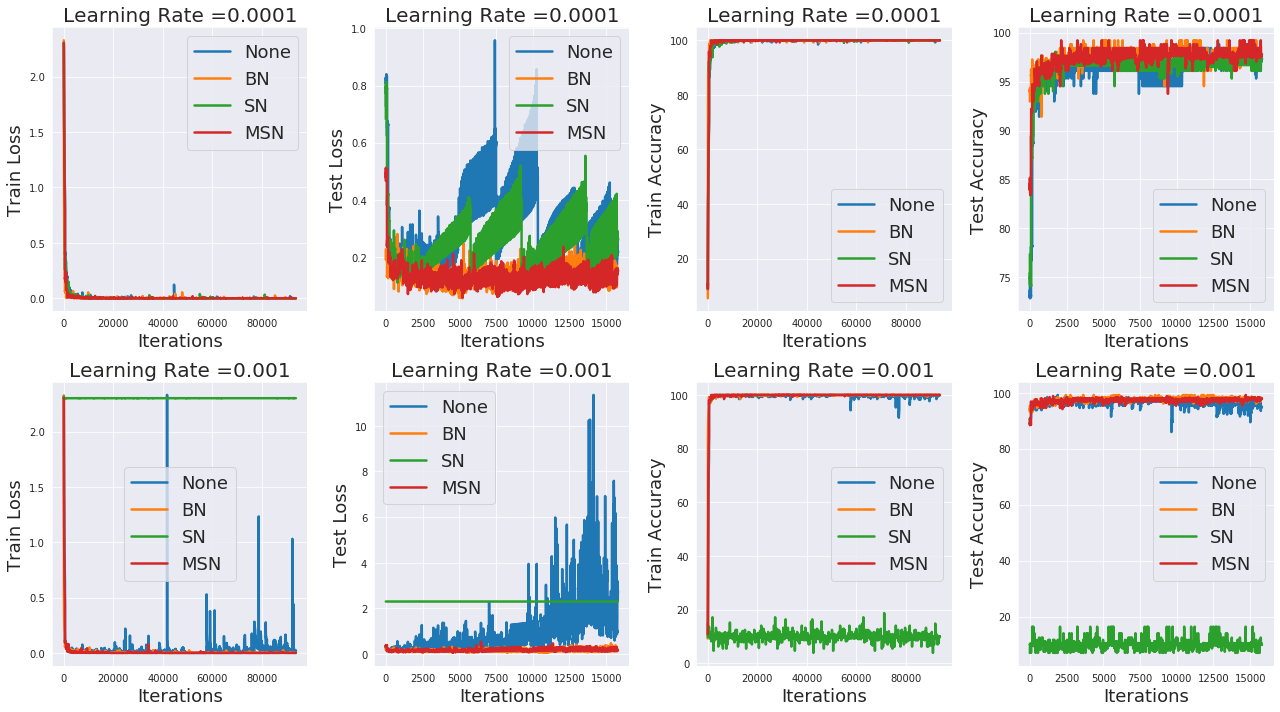

In [3]:
k = 0
LRS = [0.0001, 0.001]
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook([None,'BN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"VGG_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"VGG_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"VGG_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"VGG_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Act_Norm_Results.pdf', dpi=400)

0
0
0


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

4
4
4



/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating 

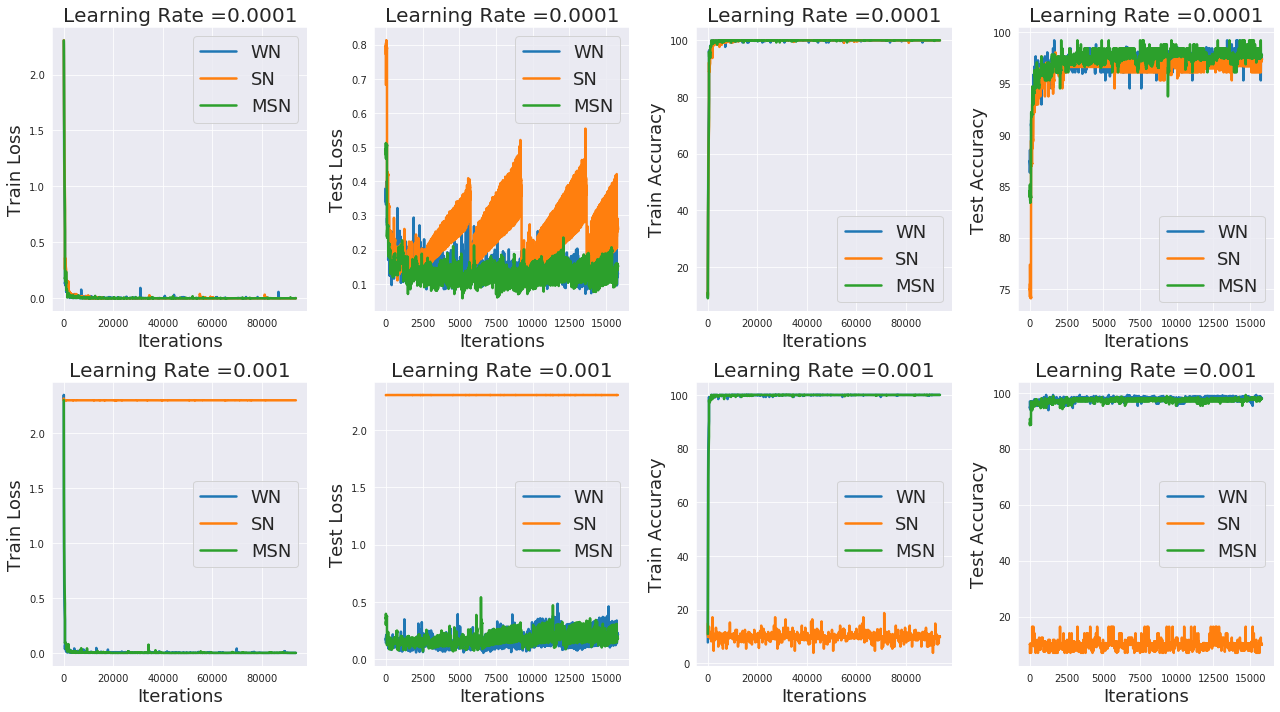

In [4]:
k = 0
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['WN', 'SN', 'MSN'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"VGG_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"VGG_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"VGG_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"VGG_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_Results.pdf', dpi=400)

0
0


/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

4
4



/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/antixk/miniconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationW

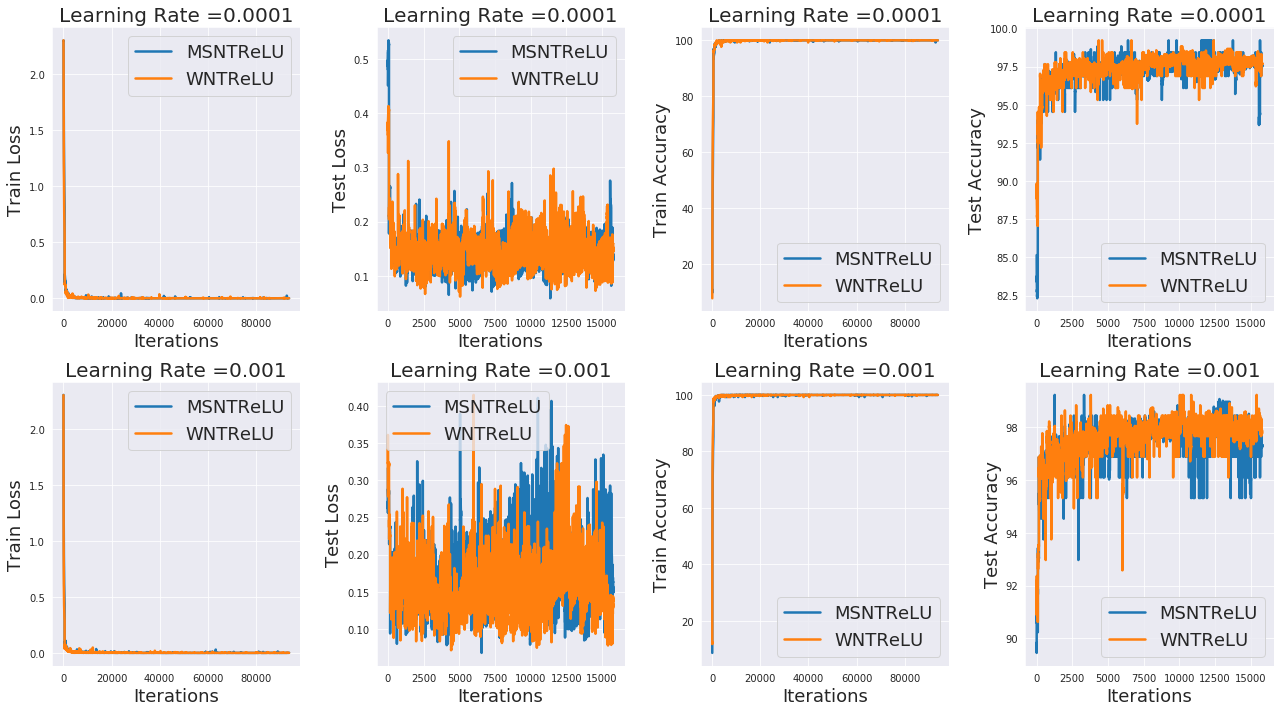

In [5]:
k = 0
plt.figure(figsize=(18, 10))
for i, lr in enumerate(tqdm_notebook(LRS)):    
    for j, norm in enumerate(tqdm_notebook(['MSNTReLU', 'WNTReLU'])):
        print(k)
        train_loss_log = np.load(SAVE_PATH+"VGG_Train_loss_{}_{}.npy".format(norm,lr) )  
        test_loss_log = np.load(SAVE_PATH+"VGG_Test_loss_{}_{}.npy".format(norm,lr))    
        train_acc_log = np.load(SAVE_PATH+"VGG_Train_Acc_{}_{}.npy".format(norm,lr))    
        test_acc_log= np.load(SAVE_PATH+"VGG_Test_Acc_{}_{}.npy".format(norm,lr))   
        
        ax = plt.subplot(2,4,k+1)
        plt.plot(train_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Loss', fontsize=18)     
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+2)
        plt.plot(test_loss_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Loss', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);

        ax = plt.subplot(2,4,k+3)
        plt.plot(train_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Train Accuracy', fontsize=18) 
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
                
        ax = plt.subplot(2,4,k+4)
        plt.plot(test_acc_log, lw=2.5, label=str(norm))
        plt.xlabel('Iterations', fontsize=18)
        plt.ylabel('Test Accuracy', fontsize=18)        
        plt.legend(fontsize=18)
        plt.grid(True)
        plt.title("Learning Rate ={}".format(lr), fontsize=20);
    k+= 4
plt.tight_layout()
plt.savefig(SAVE_PATH+'Weight_reparam_act_Results.pdf', dpi=400)